<a href="https://colab.research.google.com/github/jooyeongkang/social-injustice-mimic-III/blob/main/Medication_Race_2_1_Draft.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [617]:
from google.colab import drive
drive.mount('/content/drive')

'''from google.colab import files
uploaded = files.upload()'''

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


'from google.colab import files\nuploaded = files.upload()'

# Install Libraries
---

In [618]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.utils import resample
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.sandbox.stats.multicomp import MultiComparison
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats

from IPython.display import display

# **Load Data**

---



## ADMISSIONS.csv

In [619]:
#df_admission = pd.read_csv('../mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
df_admission = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/ADMISSIONS.csv')
print(df_admission.shape)
df_admission.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## PATIENTS.csv

In [620]:
#df_patient = pd.read_csv('../mimic-iii-clinical-database-1.4/PATIENTS.csv')
df_patient = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/PATIENTS.csv')
print(df_patient.shape)
df_patient.head()

(46520, 8)


,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13 00:00:00,NaN,NaN,NaN,0
1,235,250,F,2164-12-27 00:00:00,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15 00:00:00,NaN,NaN,NaN,0
3,237,252,M,2078-03-06 00:00:00,NaN,NaN,NaN,0
4,238,253,F,2089-11-26 00:00:00,NaN,NaN,NaN,0


## **DIAGNOSES_ICD**.csv

In [621]:
#df_diagnoses_icd = pd.read_csv('../mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv')
df_diagnoses_icd = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/DIAGNOSES_ICD.csv')
print(df_diagnoses_icd.shape)
df_diagnoses_icd.head()

(651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


## PRESCRIPTIONS.csv

In [622]:
#df_prescription = pd.read_csv('../mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
df_prescription = pd.read_csv('/content/drive/MyDrive/UT Austin/Spring-2021/AI in Health/mimic-iii-clinical-database-1.4/PRESCRIPTIONS.csv')
print(df_prescription.shape)
df_prescription.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(4156450, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


# Define Functions
---

In [623]:
def countplot(data, column, figsize):
    
    fig, ax = plt.subplots(figsize=figsize)
    
    count_plot = sns.countplot(x=column, data=data, ax=ax)

    # Display count for each bar
    count_plot.set_xticklabels(count_plot.get_xticklabels())
    for p in count_plot.patches:
        height = p.get_height()
        count_plot.text(p.get_x()+p.get_width()/2., height + 0.1, height,ha="center")
    plt.show()


def unsampling(df):
  # Oversample the minority class by using SMOTE
  white = df.loc[df['ETHNICITY'] == 'WHITE']
  others = df.loc[(df['ETHNICITY'] == 'BLACK/AFRICAN AMERICAN') | (df['ETHNICITY'] == 'HISPANIC/LATINO') |
                  (df['ETHNICITY'] == 'ASIAN') | (df['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED')]

  white_undersample = resample(
      white,
      replace = False,
      n_samples = len(others),
      random_state=42
  )

  df_undersample = pd.concat([white_undersample, others], axis=0)

  # Display count for each bar
  plt.figure(figsize=(10, 5))
  count_plot = sns.countplot(x='ETHNICITY', data=df_undersample)
  count_plot.set_xticklabels(count_plot.get_xticklabels())
  for p in count_plot.patches:
      height = p.get_height()
      count_plot.text(p.get_x()+p.get_width()/2., height + 0.1, height,ha="center")
  plt.show()

  return df_undersample


def mean_race_drug(df, top_drug):
  df_mean = pd.DataFrame(ls_ethnicity, columns=['ETHNICITY'])

  for drug in top_drug:
      ls_mean = []
      
      for race in ls_ethnicity:
        ls_mean.append(df.loc[df['ETHNICITY'] == race, drug].mean())
          
      df_mean = pd.concat([df_mean, pd.DataFrame(ls_mean, columns=[drug])], axis=1)

  return df_mean


def plot_mean_race_drug(df_mean, top_drug):
  tmp = []

  for drug in df_mean:
      if drug != 'ETHNICITY':
          tmp.append(list(df_mean[drug]))

  for i in range(10, len(tmp)+1, 10):
      data = np.array(tmp[i-10:i])

      length = len(data)
      x_labels = top_drug[i-10:i]
      
      fig, ax = plt.subplots(figsize=(30, 10))
      #fig, ax = plt.subplots(figsize=(30, 10), constrained_layout=True)
      width = 1.0
      x = np.arange(0, length*8, 8)

      ax.bar(x, data[:,0], width, color='#FF3333', label='WHITE')
      ax.bar(x + width, data[:,1], width, color='#FF8333', label='UNKNOWN/NOT SPECIFIED')
      ax.bar(x + (2 * width), data[:,2], width, color='#FFDA33', label='BLACK')
      ax.bar(x + (3 * width), data[:,3], width, color='#7AFF33', label='HISPANIC/LATINO')
      ax.bar(x + (4 * width), data[:,4], width, color='#3352FF', label='ASIAN')

      ax.set_ylabel('Mean Number of Prescription')
      ax.set_ylim(0,8)
      ax.set_xticks(x + width + width/2)
      ax.set_xticklabels(x_labels)
      ax.set_xlabel('Name of Drug')
      ax.set_title('Discrimination of Drug Prescription per race')
      ax.legend()
      
      plt.show()


def analysis(df, top_drug):
  print(df.shape)
  display(df.head())

  countplot(df, 'ETHNICITY', (10,6))

  df = unsampling(df)

  df_mean = mean_race_drug(df, top_drug)
  display(df_mean)

  plot_mean_race_drug(df_mean, top_drug)

# **Preprocess Data**
---

## **ADMISSIONS.csv**

In [624]:
if df_admission.isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('ADMISSIONS.csv', df_admission.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in ADMISSIONS.csv.
The number of missing values is as follows:
ROW_ID                      0
SUBJECT_ID                  0
HADM_ID                     0
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME               53122
ADMISSION_TYPE              0
ADMISSION_LOCATION          0
DISCHARGE_LOCATION          0
INSURANCE                   0
LANGUAGE                25332
RELIGION                  458
MARITAL_STATUS          10128
ETHNICITY                   0
EDREGTIME               28099
EDOUTTIME               28099
DIAGNOSIS                  25
HOSPITAL_EXPIRE_FLAG        0
HAS_CHARTEVENTS_DATA        0
dtype: int64


### **ETHNICITY**

#### Check for missing value

In [625]:
if df_admission['ETHNICITY'].isnull().values.any() == True:
    print('Missing value exists. The number of missing values is {}'.format(df_admission['ETHNICITY'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value does not exist.


In [626]:
df_admission['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [627]:
df_admission['ETHNICITY'].replace('^WHITE\D*', 'WHITE', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^BLACK\D*', 'BLACK/AFRICAN AMERICAN', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^HISPANIC\D*', 'HISPANIC/LATINO', regex=True, inplace=True)
df_admission['ETHNICITY'].replace('^ASIAN\D*', 'ASIAN', regex=True, inplace=True)
df_admission['ETHNICITY'].loc[~df_admission['ETHNICITY'].isin(['WHITE', 'BLACK/AFRICAN AMERICAN', 'HISPANIC/LATINO', 'ASIAN'])] = 'UNKNOWN/NOT SPECIFIED'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


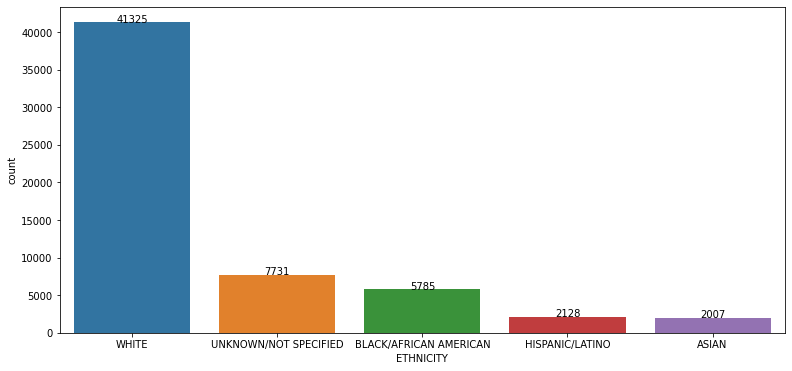

In [628]:
#value = df_admission.ETHNICITY.values
#label = df_admission.ETHNICITY.unique()
countplot(df_admission, 'ETHNICITY', (13, 6))

In [629]:
ls_ethnicity = list(df_admission['ETHNICITY'].unique())

### **ADMISSION_TYPE**

#### Check for missing value

In [630]:
if df_admission['ADMISSION_TYPE'].isnull().values.any() == True:
    print('Missing value exists. The number of missing values is {}'.format(df_admission['ADMISSION_TYPE'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value does not exist.


In [631]:
df_admission['ADMISSION_TYPE'].unique()

array(['EMERGENCY', 'ELECTIVE', 'NEWBORN', 'URGENT'], dtype=object)

ADMISSION_TYPE describes the type of the admission: ‘ELECTIVE’, ‘URGENT’, ‘NEWBORN’ or ‘EMERGENCY’. Emergency/urgent indicate unplanned medical care, and are often collapsed into a single category in studies. Elective indicates a previously planned hospital admission. Newborn indicates that the HADM_ID pertains to the patient’s birth.

#### Merge columns

In [632]:
df_admission['ADMISSION_TYPE'].replace('URGENT', 'EMERGENCY', inplace=True)

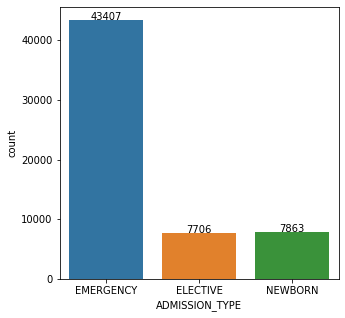

In [633]:
countplot(df_admission, 'ADMISSION_TYPE', (5, 5))

### **MARITAL_STATUS**

#### Check for missing value

In [634]:
if df_admission['MARITAL_STATUS'].isnull().values.any() == True:
    print('Missing value exists. The number of missing values is {}'.format(df_admission['MARITAL_STATUS'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists. The number of missing values is 10128


#### Impute missing values

In [635]:
df_admission['MARITAL_STATUS'].fillna('UNKNOWN (DEFAULT)', inplace=True)

# Confirm the imputation
df_admission['MARITAL_STATUS'].isnull().values.any()

False

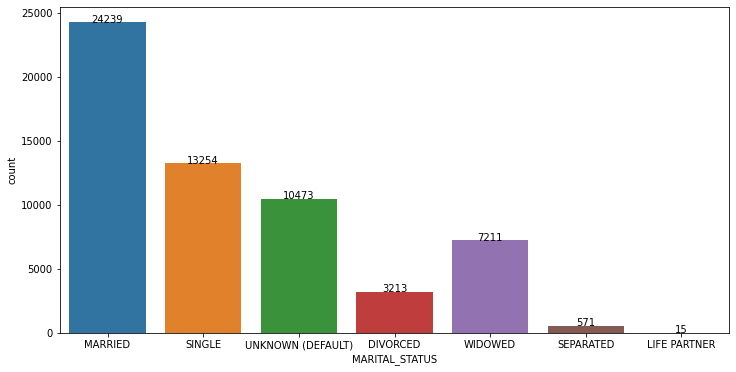

In [636]:
countplot(df_admission, 'MARITAL_STATUS', (12, 6))

#### Merge columns

In [637]:
df_admission.MARITAL_STATUS.replace('WIDOWED', 'SINGLE', inplace=True)
df_admission.MARITAL_STATUS.replace('DIVORCED', 'SINGLE', inplace=True)
df_admission.MARITAL_STATUS.replace('SEPARATED', 'UNKNOWN (DEFAULT)', inplace=True)
df_admission.MARITAL_STATUS.replace('LIFE PARTNER', 'UNKNOWN (DEFAULT)', inplace=True)

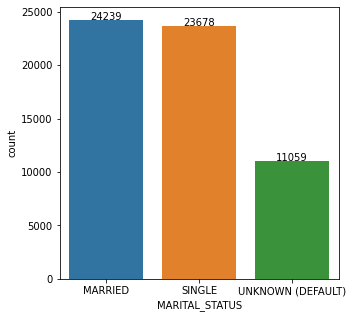

In [638]:
countplot(df_admission, 'MARITAL_STATUS', (5, 5))

### **RELIGION**

#### Check for missing value

In [639]:
if df_admission['RELIGION'].isnull().values.any() == True:
    print('Missing value exists. The number of missing values is {}'.format(df_admission['RELIGION'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists. The number of missing values is 458


#### Impute missing values

In [640]:
df_admission['RELIGION'].fillna('UNOBTAINABLE', inplace=True)
df_admission['RELIGION'].isnull().values.any()

False

In [641]:
df_admission['RELIGION'].unique()

array(['UNOBTAINABLE', 'CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'JEWISH', 'BUDDHIST', 'OTHER', "JEHOVAH'S WITNESS",
       'GREEK ORTHODOX', 'EPISCOPALIAN', 'HINDU', 'CHRISTIAN SCIENTIST',
       'HEBREW', 'METHODIST', 'UNITARIAN-UNIVERSALIST', 'BAPTIST',
       '7TH DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST. ORTH', 'LUTHERAN'],
      dtype=object)

#### Rebuild category

In [642]:
df_admission['RELIGION'].loc[~df_admission['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'RELIGIOUS'
df_admission['RELIGION'].loc[df_admission['RELIGION'].isin(['NOT SPECIFIED', 'UNOBTAINABLE'])] = 'UNKNOWN'

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


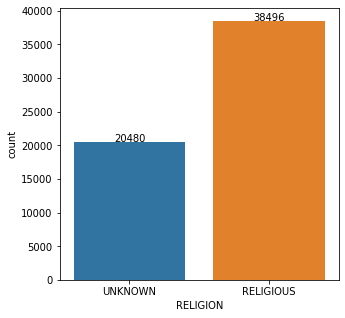

In [643]:
countplot(df_admission, 'RELIGION', (5, 5))

### **INSURANCE**

#### Check for missing value

In [644]:
if df_admission['RELIGION'].isnull().values.any() == True:
    print('Missing value exists. The number of missing values is {}'.format(df_admission['RELIGION'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value does not exist.


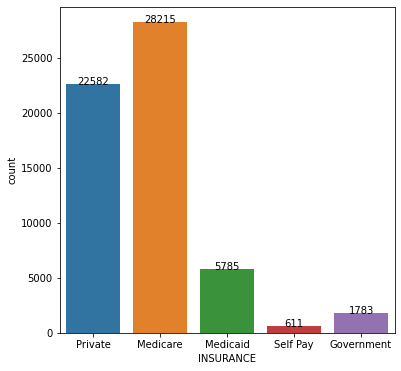

In [645]:
countplot(df_admission, 'INSURANCE', (6, 6))

In [646]:
print(df_admission.shape)
df_admission.head()

(58976, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,21,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNKNOWN,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0,1
1,22,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
2,23,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,RELIGIOUS,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0,1
3,24,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,RELIGIOUS,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0,1
4,25,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNKNOWN,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0,1


## Copy df_admission to df

In [647]:
diagnosis_top_10 = list(df_admission['DIAGNOSIS'].value_counts()[1:11].keys())

df = df_admission.loc[df_admission['DIAGNOSIS'].isin(diagnosis_top_10)]
#df = df[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS']]
print(df.shape)
df.head()

(8570, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
15,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1
18,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1
22,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1
24,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1
25,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1


## PATIENTS.csv

In [648]:
if df_patient.isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('PATIENTS.csv', df_patient.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in PATIENTS.csv.
The number of missing values is as follows:
ROW_ID             0
SUBJECT_ID         0
GENDER             0
DOB                0
DOD            30761
DOD_HOSP       36546
DOD_SSN        33142
EXPIRE_FLAG        0
dtype: int64


### DOB

#### Convert datatype

In [649]:
df_patient['DOB'] = pd.to_datetime(df_patient['DOB'])

## Merge df_patient and df

In [650]:
#df = df.merge(df_patient[['SUBJECT_ID', 'GENDER', 'DOB']], how='inner', on='SUBJECT_ID')
df = df.merge(df_patient, how='inner', on='SUBJECT_ID')
print(df.shape)
df.head()

(8570, 26)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1


## Create 'AGE' column

### Calculate age

In [651]:
if df['ADMITTIME'].isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('PATIENTS.csv', df['ADMITTIME'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value does not exist.


In [652]:
df_admittime_init = df[['SUBJECT_ID', 'ADMITTIME']].groupby('SUBJECT_ID').min().reset_index()
df_admittime_init.columns = ['SUBJECT_ID', 'ADMITTIME_INIT']
df_admittime_init['ADMITTIME_INIT'] = pd.to_datetime(df_admittime_init['ADMITTIME_INIT'])
print(df_admittime_init.shape)
df_admittime_init.head()

(7642, 2)


,SUBJECT_ID,ADMITTIME_INIT
0,13,2167-01-08 18:43:00
1,21,2134-09-11 12:17:00
2,36,2131-04-30 07:15:00
3,37,2183-08-21 16:48:00
4,42,2116-04-26 18:58:00


In [653]:
df = df.merge(df_admittime_init, how='outer', on='SUBJECT_ID')
print(df.shape)
df.head()

(8570, 27)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00


In [654]:
df['AGE'] = round((df['ADMITTIME_INIT'].sub(df['DOB'], axis=0))/np.timedelta64(1, 'Y'), 0)
print(df.shape)
df.head()

(8570, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,70.0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,69.0
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0


### Filter abnormal rows

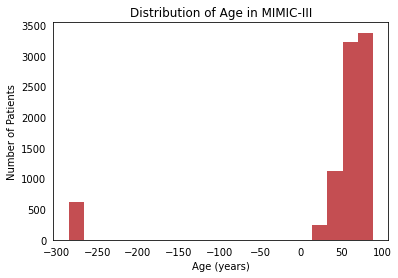

In [655]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['AGE'], bins=20, color='#c44e52')
plt.ylabel('Number of Patients')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

In [656]:
df = df.loc[df['AGE'] >= 0]
print(df.shape)
df.head()

(7956, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,70.0
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,69.0
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,63.0


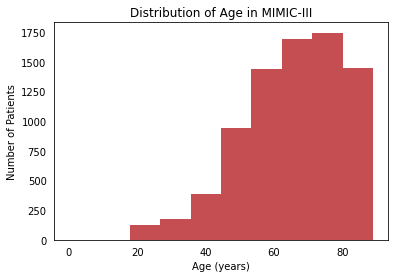

In [657]:
# Note that no ‘middle’ patients show up - this reflects the fact that MIMIC-III does not contain data from pediatric patients.
plt.hist(df['AGE'], bins=10, color='#c44e52')
plt.ylabel('Number of Patients')
plt.xlabel('Age (years)')
plt.title('Distribution of Age in MIMIC-III')
plt.tick_params(left=False, bottom=False, top=False, right=False) 
plt.show();

In [658]:
age_range = [(0, 20), (20, 40), (40, 60), (60, 100)]

age_dict = {0: 'minor',
            1: 'young_adult',
            2: 'middle_adult',
            3: 'senior'}

for num, category_range in enumerate(age_range):
    df['AGE'] = np.where(df['AGE'].between(category_range[0], category_range[1]), num, df['AGE'])
    
df['AGE'] = df['AGE'].replace(age_dict)
df['AGE'].value_counts()

senior          5264
middle_adult    2226
young_adult      432
minor             34
Name: AGE, dtype: int64

In [659]:
#df = df.drop(['ADMITTIME', 'DOB', 'ADMITTIME_INIT'], axis=1)
print(df.shape)
df.head()

(7956, 28)


,ROW_ID_x,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA,ROW_ID_y,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME_INIT,AGE
0,36,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,NaN,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME HEALTH CARE,Medicare,ENGL,UNKNOWN,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0,1,32,M,2061-08-17,NaN,NaN,NaN,0,2131-04-30 07:15:00,senior
1,39,37,188670,2183-08-21 16:48:00,2183-08-26 18:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,NaN,RELIGIOUS,MARRIED,WHITE,2183-08-21 05:58:00,2183-08-21 17:45:00,CONGESTIVE HEART FAILURE,0,1,33,M,2114-09-17,2185-01-06 00:00:00,2185-01-06 00:00:00,2185-01-06 00:00:00,1,2183-08-21 16:48:00,senior
2,456,357,174486,2197-12-06 07:13:00,2198-01-03 14:00:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2197-12-06 06:28:00,2197-12-06 07:43:00,GASTROINTESTINAL BLEED,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior
3,458,357,122609,2198-11-01 22:36:00,2198-11-14 14:20:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Private,ENGL,UNKNOWN,MARRIED,WHITE,2198-11-01 18:01:00,2198-11-01 23:06:00,SEPSIS,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior
4,459,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Private,ENGL,UNKNOWN,MARRIED,WHITE,2199-10-20 09:34:00,2199-10-20 13:25:00,PNEUMONIA,0,1,336,M,2135-03-22,2201-08-02 00:00:00,2201-08-02 00:00:00,2201-08-02 00:00:00,1,2197-12-06 07:13:00,senior


## Drop unnecessary columns

In [660]:
df = df.drop(['ROW_ID_x', 'SUBJECT_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'LANGUAGE',
       'EDREGTIME', 'EDOUTTIME', 'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA', 'ROW_ID_y',
       'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN', 'EXPIRE_FLAG', 'ADMITTIME_INIT'], axis=1)

print(df.shape)
df.head()

(7956, 9)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE
0,182104,EMERGENCY,Medicare,UNKNOWN,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,M,senior
1,188670,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,CONGESTIVE HEART FAILURE,M,senior
2,174486,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,GASTROINTESTINAL BLEED,M,senior
3,122609,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,SEPSIS,M,senior
4,101651,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,PNEUMONIA,M,senior


## Create df for each diagnosis

In [661]:
diagnosis_top_10

['PNEUMONIA',
 'SEPSIS',
 'CONGESTIVE HEART FAILURE',
 'CORONARY ARTERY DISEASE',
 'CHEST PAIN',
 'INTRACRANIAL HEMORRHAGE',
 'ALTERED MENTAL STATUS',
 'GASTROINTESTINAL BLEED',
 'CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA',
 'UPPER GI BLEED']

In [662]:
ls_df_diagnosis = []

for diagnosis in diagnosis_top_10:
  locals()['df_'+ diagnosis.lower().replace(' ', '_')] = df.loc[df['DIAGNOSIS'] == diagnosis]
  ls_df_diagnosis.append('df_'+ diagnosis.lower().replace(' ', '_'))

In [663]:
print(df_pneumonia.shape)
df_pneumonia.head()

(1375, 9)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE
4,101651,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,PNEUMONIA,M,senior
9,123421,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,F,senior
12,170467,EMERGENCY,Medicare,RELIGIOUS,SINGLE,BLACK/AFRICAN AMERICAN,PNEUMONIA,F,middle_adult
13,112077,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,M,senior
15,140037,EMERGENCY,Medicare,UNKNOWN,MARRIED,ASIAN,PNEUMONIA,M,senior


In [664]:
print(df_congestive_heart_failure.shape)
df_congestive_heart_failure.head()

(812, 9)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE
1,188670,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,CONGESTIVE HEART FAILURE,M,senior
10,119203,EMERGENCY,Private,RELIGIOUS,MARRIED,UNKNOWN/NOT SPECIFIED,CONGESTIVE HEART FAILURE,M,senior
25,109451,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,CONGESTIVE HEART FAILURE,M,senior
27,122211,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,CONGESTIVE HEART FAILURE,F,senior
28,106158,EMERGENCY,Medicare,RELIGIOUS,SINGLE,WHITE,CONGESTIVE HEART FAILURE,M,middle_adult


## **PRESCRIPTION.csv**

In [665]:
if df_prescription.isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('PRESCRIPTIONS.csv', df_prescription.isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value exists in PRESCRIPTIONS.csv.
The number of missing values is as follows:
ROW_ID                     0
SUBJECT_ID                 0
HADM_ID                    0
ICUSTAY_ID           1447708
STARTDATE               3182
ENDDATE                 5421
DRUG_TYPE                  0
DRUG                       0
DRUG_NAME_POE        1664234
DRUG_NAME_GENERIC    1662989
FORMULARY_DRUG_CD       1933
GSN                   507164
NDC                     4463
PROD_STRENGTH           1362
DOSE_VAL_RX             1350
DOSE_UNIT_RX            1342
FORM_VAL_DISP           1355
FORM_UNIT_DISP          1409
ROUTE                   1156
dtype: int64


### DRUG

In [666]:
if df_prescription['DRUG'].isnull().values.any() == True:
    print('Missing value exists in {}.\nThe number of missing values is as follows:\n{}'.format('PRESCRIPTIONS.csv', df_prescription['DRUG'].isnull().sum()))
else:
    print('Missing value does not exist.')

Missing value does not exist.


In [667]:
print(df_prescription.shape)
df_prescription.head()

(4156450, 19)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,469061711.0,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,56017275.0,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,338055002.0,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0.0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,54829725.0,20mg Tablet,20,mg,1,TAB,PO


In [669]:
for diagnosis in ls_df_diagnosis:
  locals()[diagnosis+'_tmp'] = locals()[diagnosis].merge(df_prescription[['HADM_ID', 'DRUG']], how='inner', on='HADM_ID')

In [670]:
for diagnosis in ls_df_diagnosis:
  locals()['top_drug_'+diagnosis] = list(locals()[diagnosis+'_tmp']['DRUG'].value_counts().nlargest(10).keys())
  tmp = locals()[diagnosis+'_tmp'].loc[locals()[diagnosis+'_tmp']['DRUG'].isin(locals()['top_drug_'+diagnosis])]
  tmp_2 = tmp.groupby('HADM_ID')['DRUG'].apply(list).reset_index()
  ls_drug = pd.get_dummies(tmp_2['DRUG'].apply(pd.Series).stack()).sum(level=0)
  tmp_2 = tmp_2.join(ls_drug, how='outer')
  tmp_2.drop(['DRUG'], axis=1, inplace=True)
  locals()[diagnosis] = locals()[diagnosis].merge(tmp_2, how='inner', on='HADM_ID')

# Diagnosis: Pneumonia

(1307, 19)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE,0.9% Sodium Chloride,5% Dextrose,D5W,Furosemide,Insulin,Iso-Osmotic Dextrose,Magnesium Sulfate,NS,Potassium Chloride,Vancomycin
0,101651,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,PNEUMONIA,M,senior,0,1,0,0,7,1,0,0,5,1
1,170467,EMERGENCY,Medicare,RELIGIOUS,SINGLE,BLACK/AFRICAN AMERICAN,PNEUMONIA,F,middle_adult,0,0,7,4,0,1,6,16,8,0
2,112077,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,M,senior,4,0,0,0,0,3,3,0,0,3
3,140037,EMERGENCY,Medicare,UNKNOWN,MARRIED,ASIAN,PNEUMONIA,M,senior,0,0,6,1,0,6,1,18,9,0
4,155897,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,PNEUMONIA,F,senior,3,6,0,0,1,2,0,0,0,1


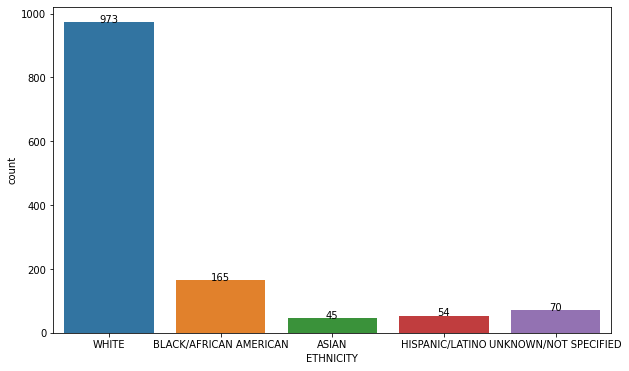

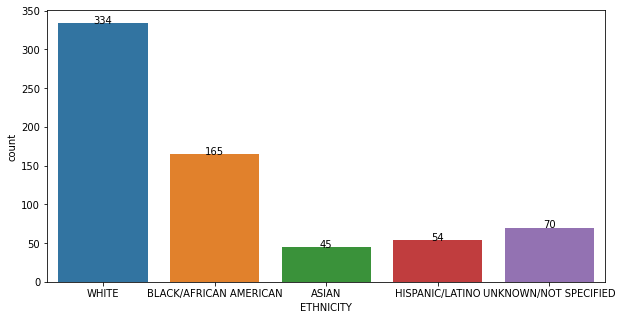

,ETHNICITY,Potassium Chloride,0.9% Sodium Chloride,Iso-Osmotic Dextrose,Furosemide,NS,Insulin,D5W,Vancomycin,5% Dextrose,Magnesium Sulfate
0,WHITE,3.715569,3.263473,3.104790,3.005988,3.047904,2.658683,2.446108,1.976048,1.727545,1.793413
1,UNKNOWN/NOT SPECIFIED,4.557143,3.942857,3.171429,3.785714,2.471429,2.400000,2.785714,1.771429,2.442857,1.628571
2,BLACK/AFRICAN AMERICAN,3.557576,5.436364,2.830303,2.563636,2.200000,2.381818,1.684848,2.000000,2.490909,1.860606
3,HISPANIC/LATINO,3.351852,2.685185,3.611111,2.777778,4.240741,3.074074,3.129630,2.037037,1.648148,1.740741
4,ASIAN,5.000000,5.155556,2.911111,1.800000,3.911111,2.622222,1.244444,1.733333,2.177778,1.888889


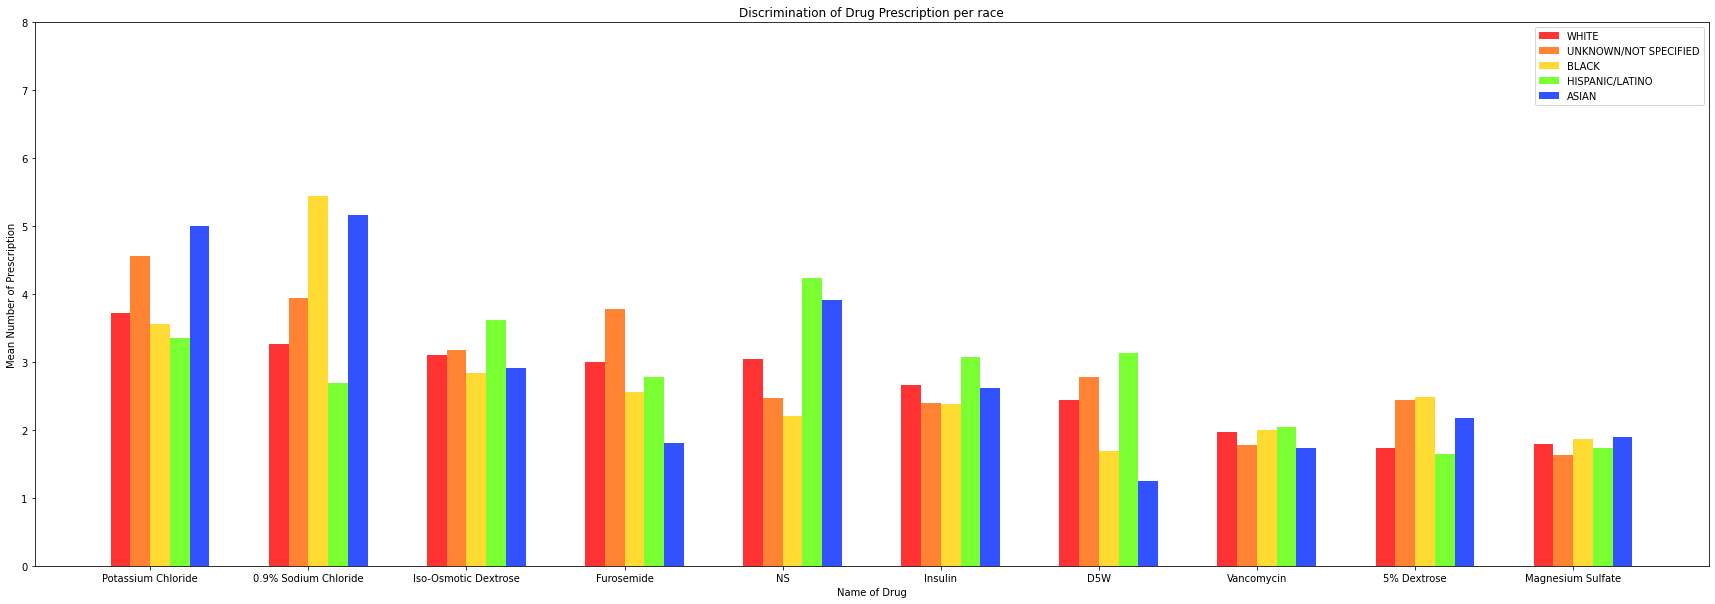

In [671]:
analysis(df_pneumonia, top_drug_df_pneumonia)

# Diagnosis: Sepsis

(1042, 19)


,HADM_ID,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,GENDER,AGE,0.9% Sodium Chloride,5% Dextrose,D5W,Furosemide,Insulin,Iso-Osmotic Dextrose,Magnesium Sulfate,NS,Potassium Chloride,SW
0,122609,EMERGENCY,Private,UNKNOWN,MARRIED,WHITE,SEPSIS,M,senior,0,0,6,5,25,2,1,6,15,6
1,134462,EMERGENCY,Medicare,RELIGIOUS,SINGLE,HISPANIC/LATINO,SEPSIS,M,middle_adult,0,0,1,0,0,3,1,8,0,0
2,183686,EMERGENCY,Medicare,UNKNOWN,MARRIED,ASIAN,SEPSIS,M,senior,0,0,1,0,1,1,1,11,7,1
3,111970,EMERGENCY,Medicare,RELIGIOUS,MARRIED,WHITE,SEPSIS,M,senior,0,0,7,0,4,2,5,13,2,2
4,108923,EMERGENCY,Medicare,RELIGIOUS,SINGLE,WHITE,SEPSIS,M,senior,0,0,2,0,1,5,0,1,0,0


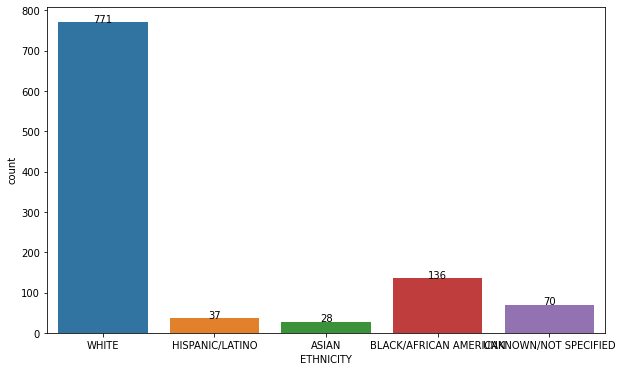

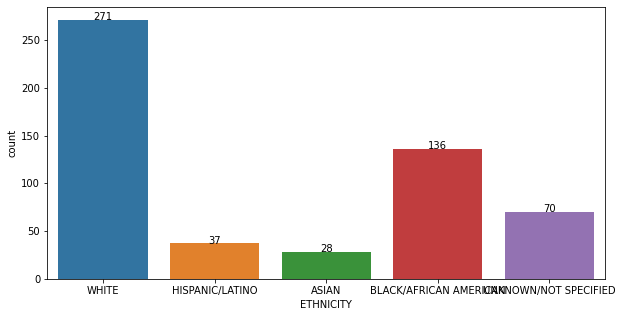

,ETHNICITY,Potassium Chloride,NS,D5W,Iso-Osmotic Dextrose,Insulin,0.9% Sodium Chloride,Furosemide,Magnesium Sulfate,SW,5% Dextrose
0,WHITE,5.361624,5.627306,4.520295,3.690037,3.225092,3.136531,2.664207,2.649446,2.619926,2.158672
1,UNKNOWN/NOT SPECIFIED,4.657143,5.014286,6.228571,3.571429,3.142857,2.614286,3.771429,2.085714,2.057143,1.257143
2,BLACK/AFRICAN AMERICAN,3.926471,4.742647,4.058824,3.507353,3.404412,2.529412,1.698529,2.235294,1.933824,1.404412
3,HISPANIC/LATINO,2.864865,2.702703,2.000000,3.378378,2.567568,6.540541,0.972973,1.972973,0.972973,3.540541
4,ASIAN,4.678571,2.642857,1.428571,2.500000,2.000000,4.714286,1.035714,2.035714,1.535714,2.142857


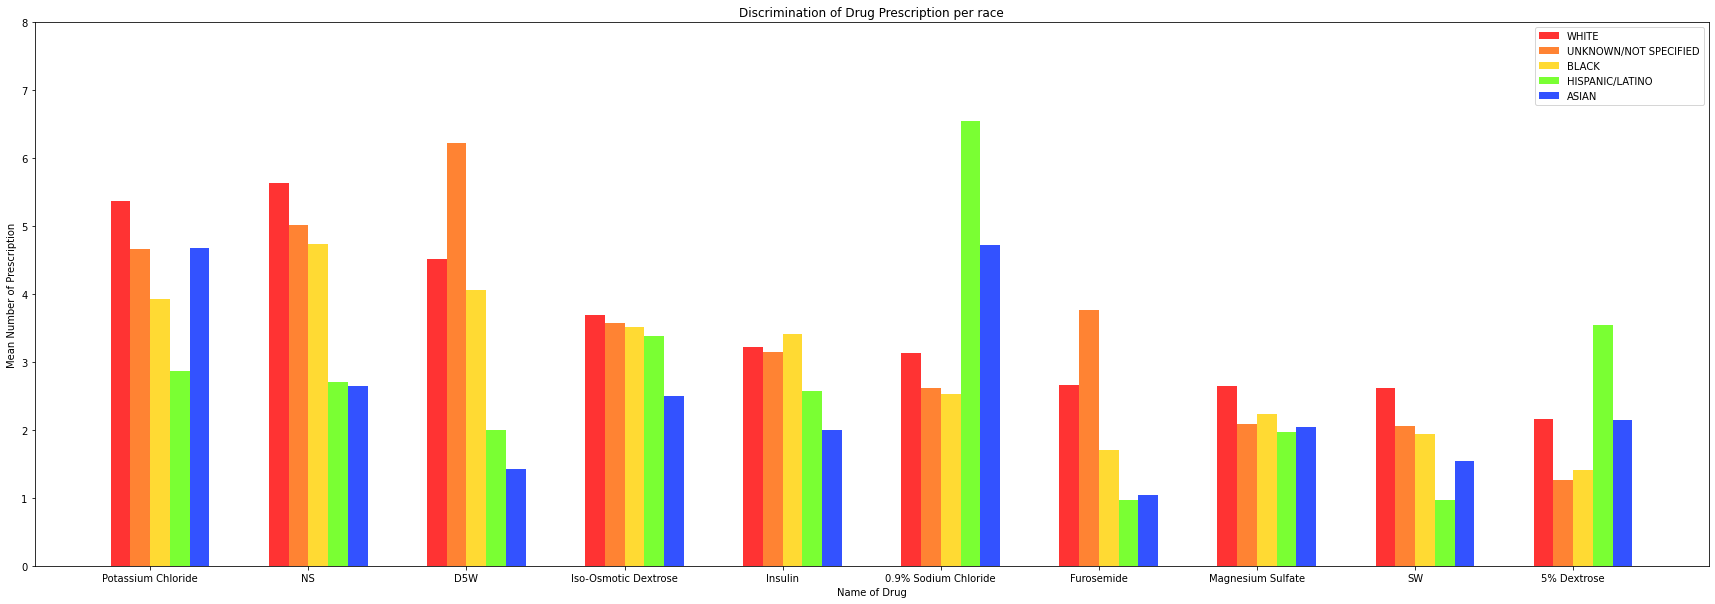

In [672]:
analysis(df_sepsis, top_drug_df_sepsis)

# Diagnosis: CONGESTIVE HEART FAILURE

In [ ]:
analysis(df_congestive_heart_failure, top_drug_df_congestive_heart_failure)

# Diagnosis: CORONARY ARTERY DISEASE

In [ ]:
analysis(df_coronary_artery_disease, top_drug_df_coronary_artery_disease)

# Diagnosis: CHEST PAIN

In [ ]:
analysis(df_chest_pain, top_drug_df_chest_pain)

# Diagnosis: INTRACRANIAL HEMORRHAGE

In [ ]:
analysis(df_intracranial_hemorrhage, top_drug_df_intracranial_hemorrhage)

# Diagnosis: ALTERED MENTAL STATUS

In [ ]:
analysis(df_altered_mental_status, top_drug_df_altered_mental_status)

# Diagnosis: GASTROINTESTINAL BLEED

In [ ]:
analysis(df_gastrointestinal_bleed, top_drug_df_gastrointestinal_bleed)

# Diagnosis: CORONARY ARTERY DISEASE\\CORONARY ARTERY BYPASS GRAFT /SDA

In [ ]:
analysis(df_coronary_artery_disease\coronary_artery_bypass_graft_/sda, top_drug_df_coronary_artery_disease\coronary_artery_bypass_graft_/sda)

# Diagnosis: UPPER GI BLEED

In [ ]:
analysis(df_upper_gi_bleed, top_drug_df_upper_gi_bleed)

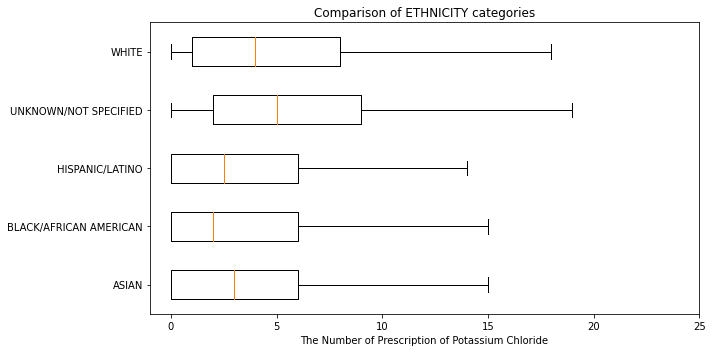

                  df         sum_sq     mean_sq         F        PR(>F)
C(ETHNICITY)     4.0    3153.258582  788.314645  16.49132  2.133936e-13
Residual      3597.0  171943.041252   47.801791       NaN           NaN


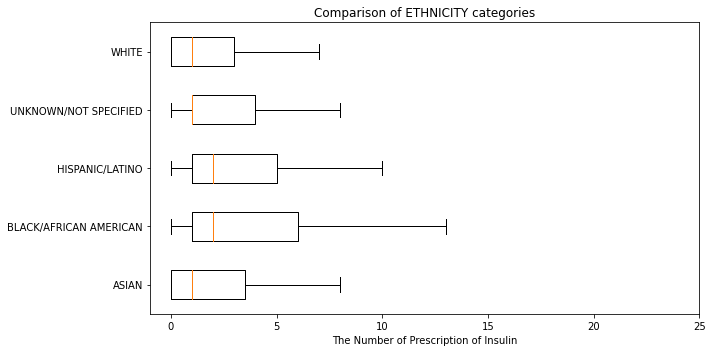

                  df         sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     466.193011  116.548253  1.292729  0.270428
Residual      3597.0  324293.840304   90.156753       NaN       NaN


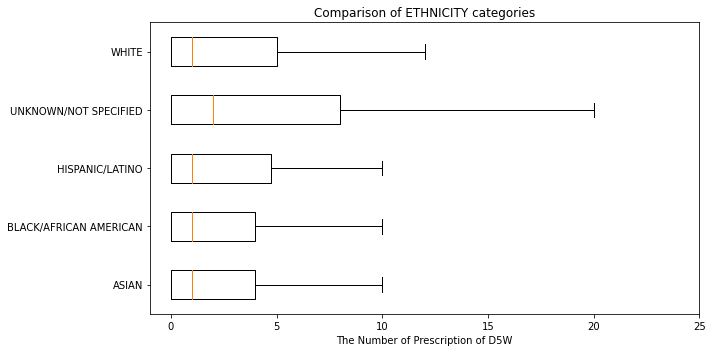

                  df         sum_sq     mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    3535.692933  883.923233  13.216749  1.085926e-10
Residual      3597.0  240563.836495   66.879020        NaN           NaN


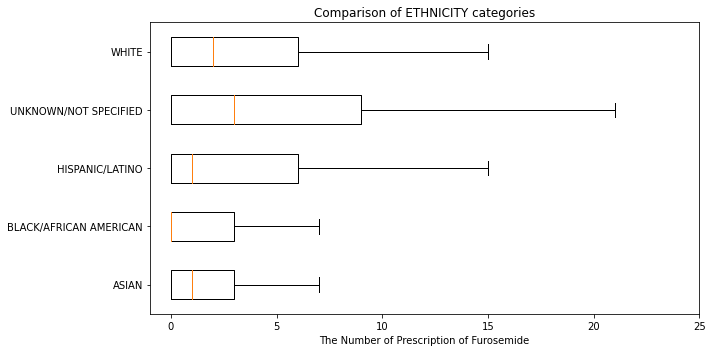

                  df         sum_sq     mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    3736.531851  934.132963  19.667812  4.982189e-16
Residual      3597.0  170841.384862   47.495520        NaN           NaN


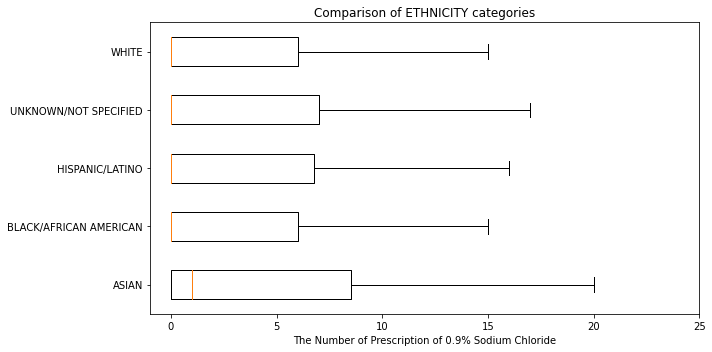

                  df         sum_sq    mean_sq         F  PR(>F)
C(ETHNICITY)     4.0     328.734749  82.183687  1.359128  0.2456
Residual      3597.0  217503.298566  60.467973       NaN     NaN


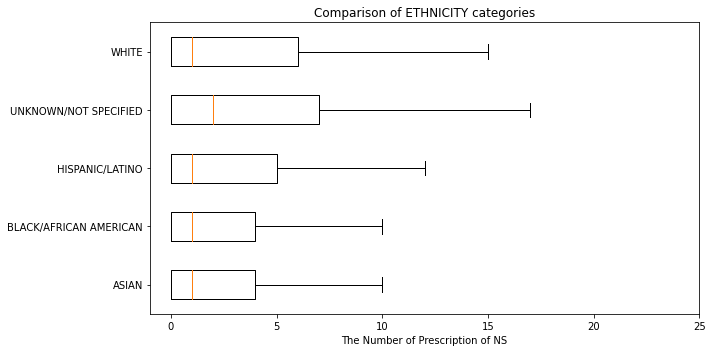

                  df         sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     806.505326  201.626331  4.096091  0.002582
Residual      3597.0  177059.029377   49.224084       NaN       NaN


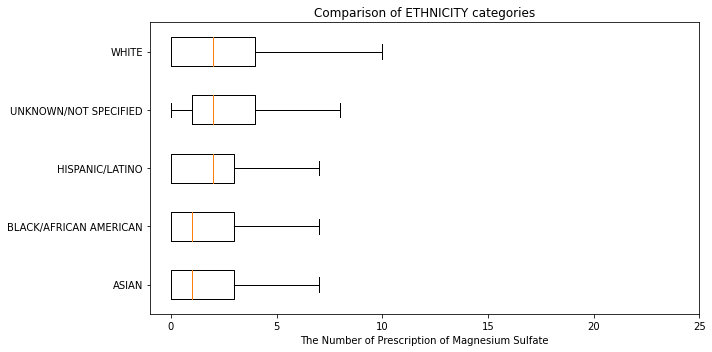

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    189.064847  47.266212  5.221463  0.000342
Residual      3597.0  32561.095064   9.052292       NaN       NaN


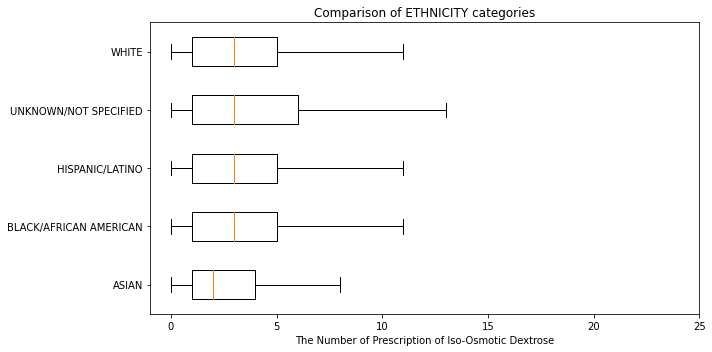

                  df        sum_sq    mean_sq         F   PR(>F)
C(ETHNICITY)     4.0    207.025236  51.756309  3.950761  0.00334
Residual      3597.0  47121.916463  13.100338       NaN      NaN


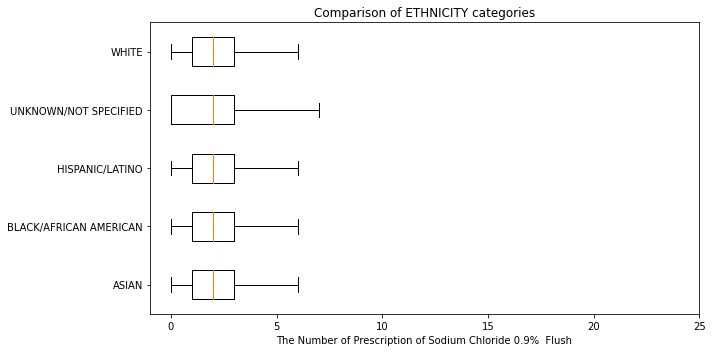

                  df        sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     19.970297  4.992574  1.643063  0.160551
Residual      3597.0  10929.760963  3.038577       NaN       NaN


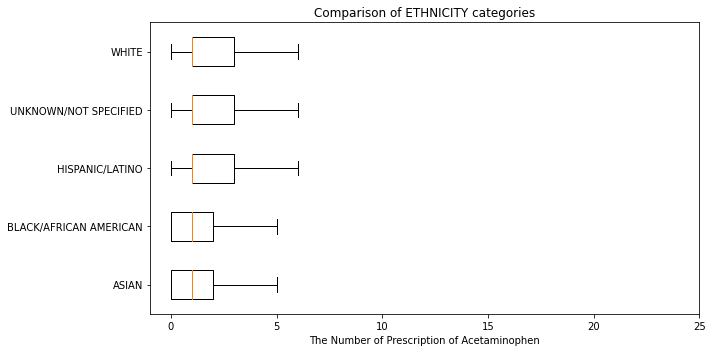

                  df        sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     56.038321  14.00958  3.846894  0.004012
Residual      3597.0  13099.519980   3.64179       NaN       NaN


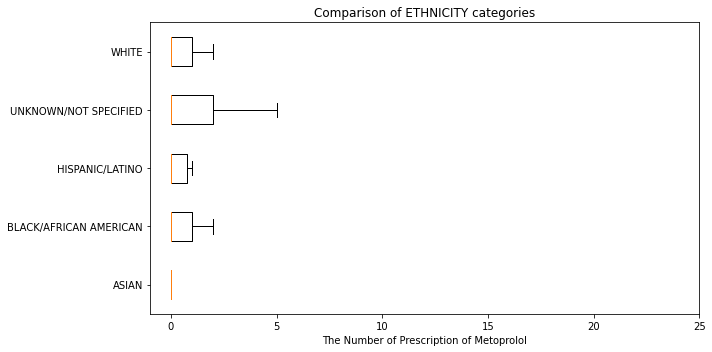

                  df        sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    407.702392  101.925598  4.862986  0.000654
Residual      3597.0  75391.200440   20.959466       NaN       NaN


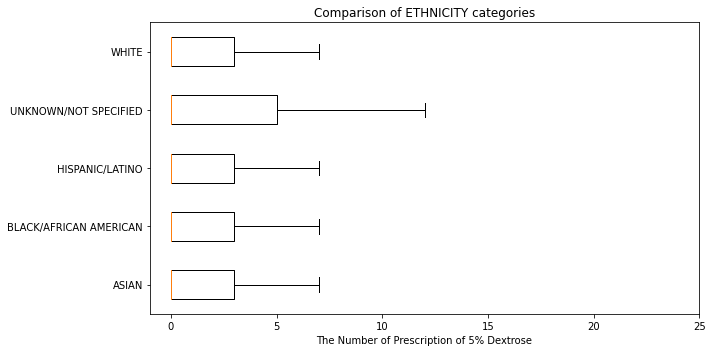

                  df         sum_sq     mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     510.767668  127.691917  3.331215  0.009882
Residual      3597.0  137879.949988   38.331929       NaN       NaN


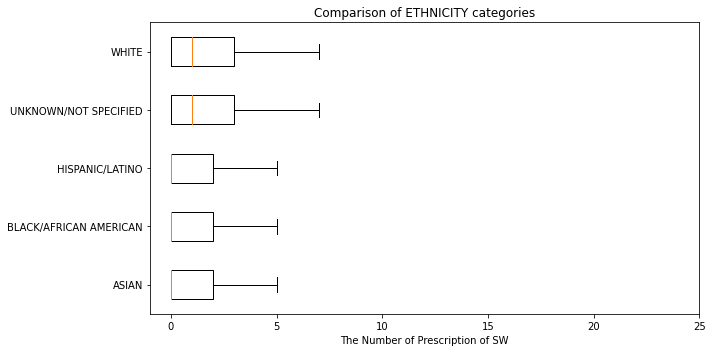

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    339.836117  84.959029  5.365158  0.000263
Residual      3597.0  56959.672211  15.835327       NaN       NaN


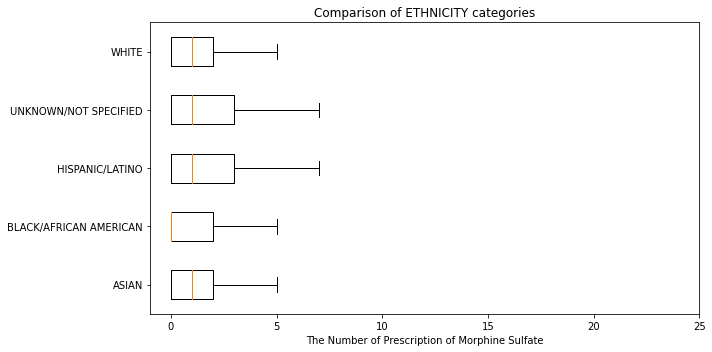

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    162.781443  40.695361  7.322097  0.000007
Residual      3597.0  19991.707452   5.557884       NaN       NaN


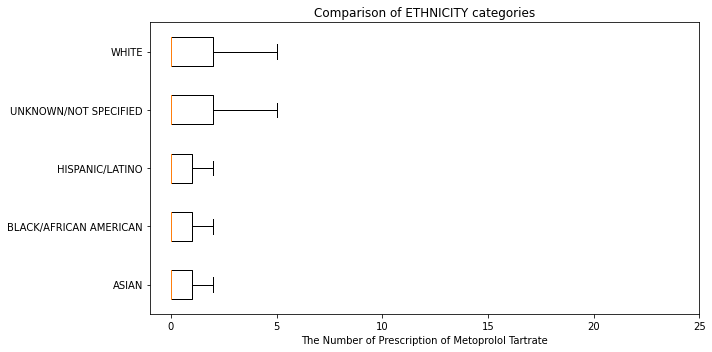

                  df       sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    312.48313  78.120783  4.478413  0.001306
Residual      3597.0  62745.54602  17.443855       NaN       NaN


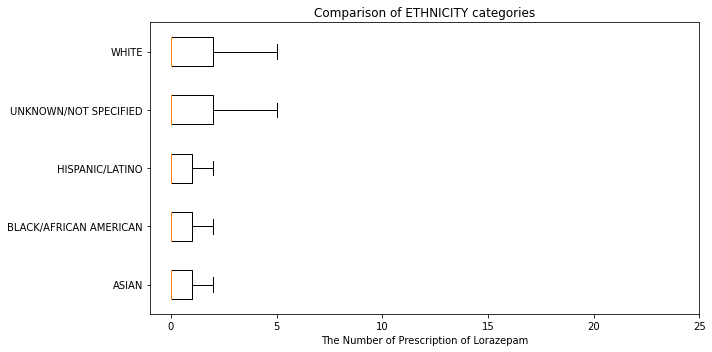

                  df        sum_sq    mean_sq        F        PR(>F)
C(ETHNICITY)     4.0    245.889245  61.472311  8.81204  4.459507e-07
Residual      3597.0  25092.477495   6.975946      NaN           NaN


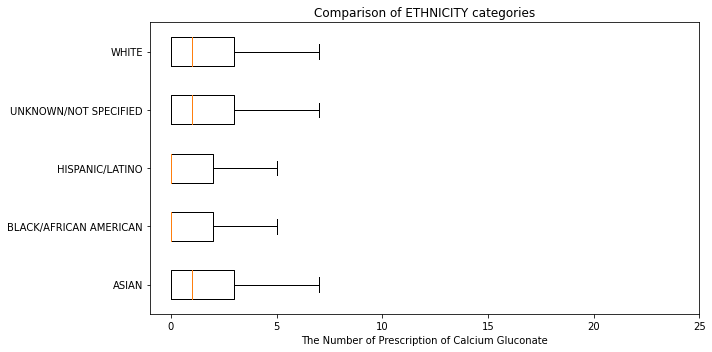

                  df       sum_sq    mean_sq         F        PR(>F)
C(ETHNICITY)     4.0    319.03596  79.758990  11.64221  2.150689e-09
Residual      3597.0  24642.49319   6.850846       NaN           NaN


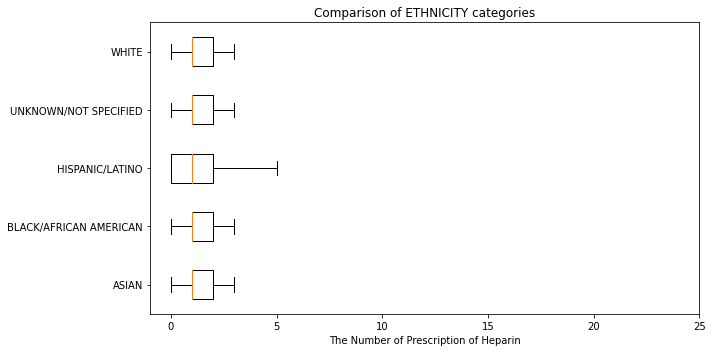

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.461037  1.865259  0.816343  0.514529
Residual      3597.0  8218.772167  2.284896       NaN       NaN


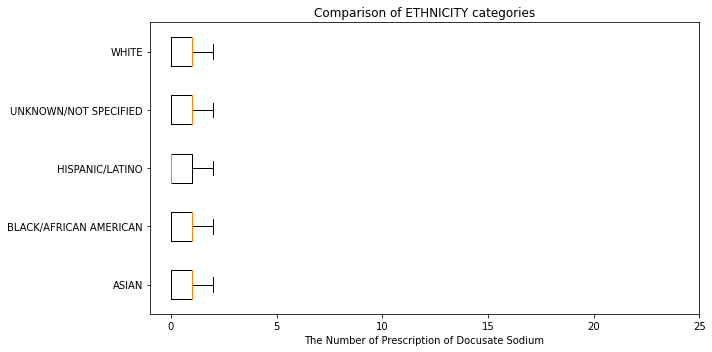

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    10.062585  2.515646  2.145708  0.072646
Residual      3597.0  4217.152296  1.172408       NaN       NaN


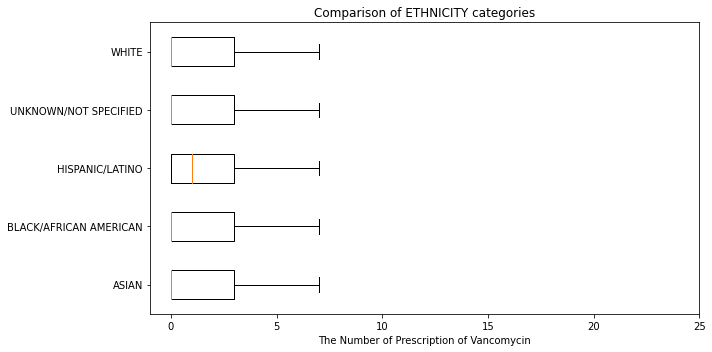

                  df        sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     14.052452  3.513113  0.396138  0.811549
Residual      3597.0  31899.643550  8.868402       NaN       NaN


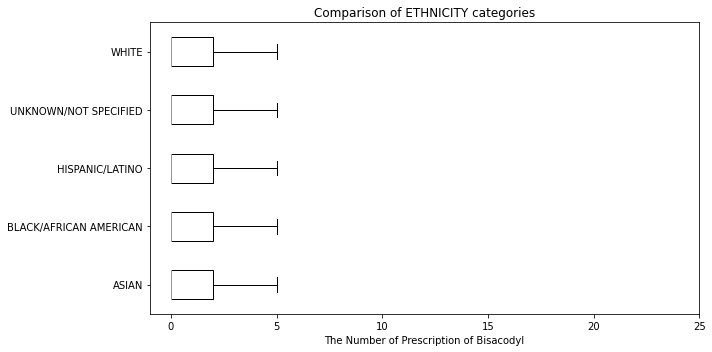

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.221606  1.805402  0.963637  0.426188
Residual      3597.0  6739.080726  1.873528       NaN       NaN


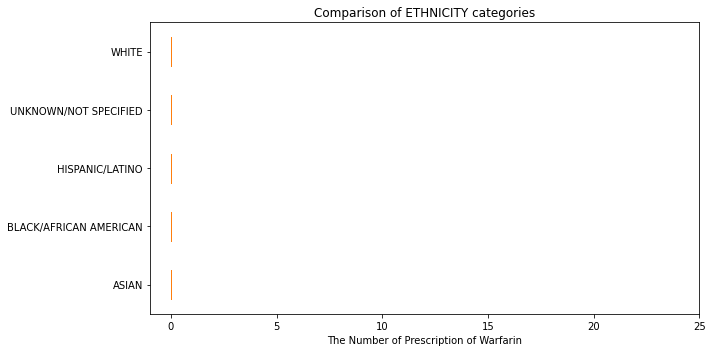

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     80.347522  20.086880  2.463876  0.043125
Residual      3597.0  29324.735487   8.152554       NaN       NaN


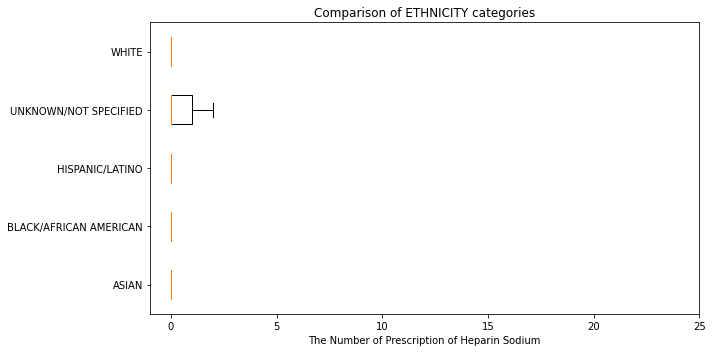

                  df        sum_sq    mean_sq         F   PR(>F)
C(ETHNICITY)     4.0    189.151462  47.287866  5.797411  0.00012
Residual      3597.0  29339.723885   8.156721       NaN      NaN


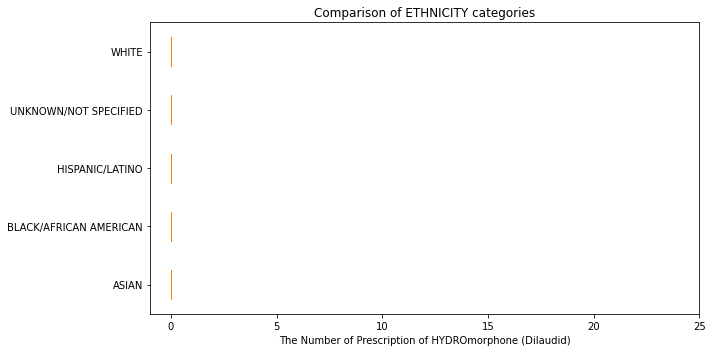

                  df        sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0     30.990146  7.747537  1.411056  0.22758
Residual      3597.0  19749.673929  5.490596       NaN      NaN


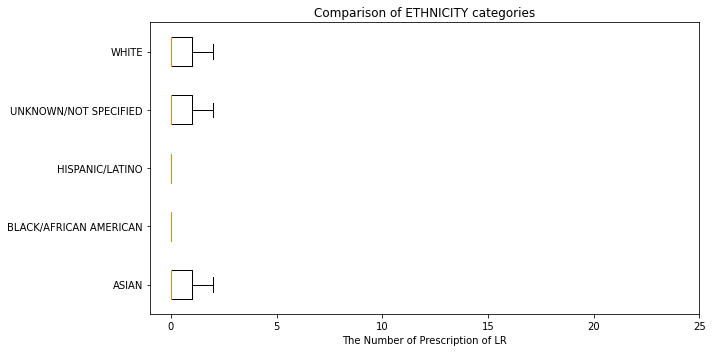

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    176.292861  44.073215  4.941144  0.000568
Residual      3597.0  32083.940621   8.919639       NaN       NaN


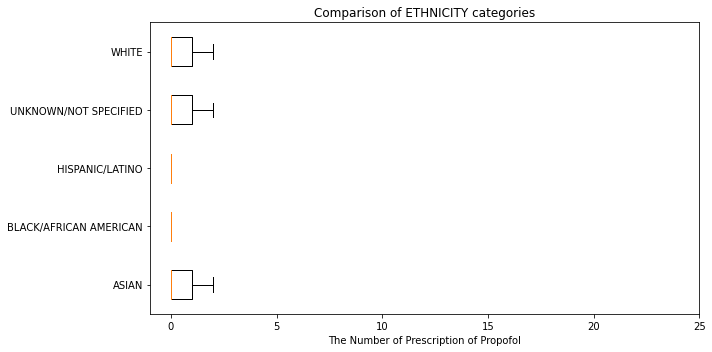

                  df       sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    65.816235  16.454059  6.044475  0.000076
Residual      3597.0  9791.627685   2.722165       NaN       NaN


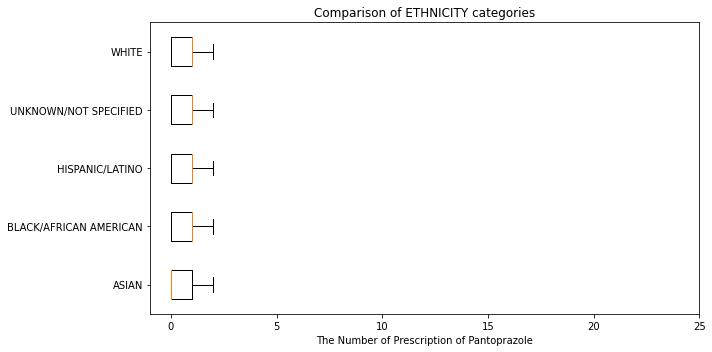

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0     6.531802  1.632951  1.117046  0.34652
Residual      3597.0  5258.264700  1.461847       NaN      NaN


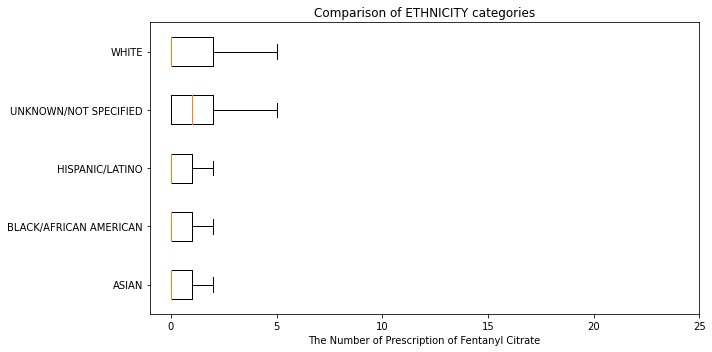

                  df        sum_sq    mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    211.727573  52.931893  13.147519  1.238509e-10
Residual      3597.0  14481.516459   4.025998        NaN           NaN


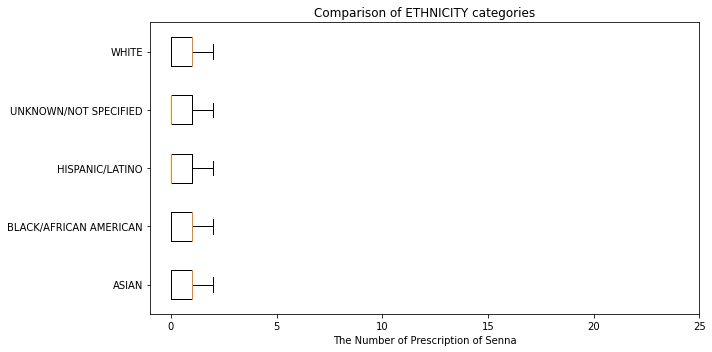

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     5.686677  1.421669  1.591993  0.173556
Residual      3597.0  3212.164517  0.893012       NaN       NaN


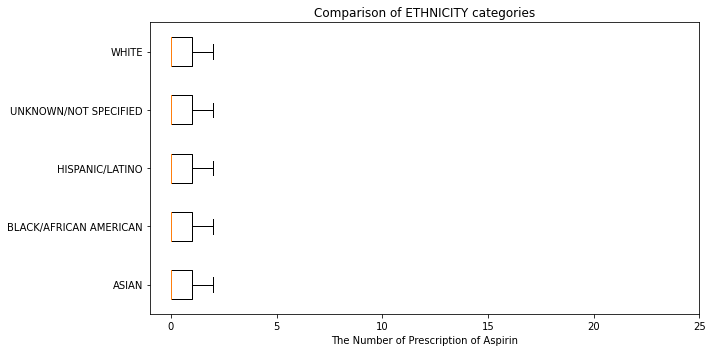

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    27.994611  6.998653  6.592266  0.000028
Residual      3597.0  3818.740814  1.061646       NaN       NaN


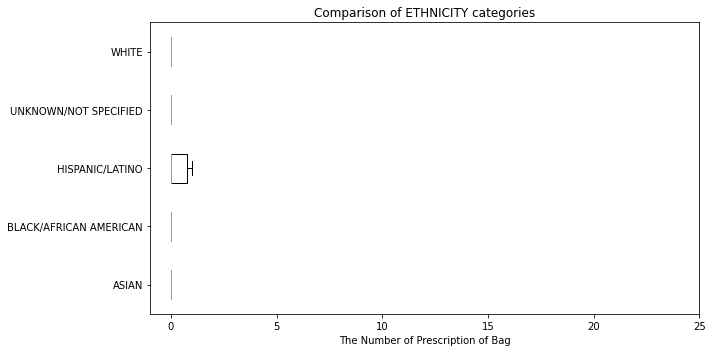

                  df        sum_sq    mean_sq        F    PR(>F)
C(ETHNICITY)     4.0     64.834555  16.208639  3.17033  0.013048
Residual      3597.0  18390.033018   5.112603      NaN       NaN


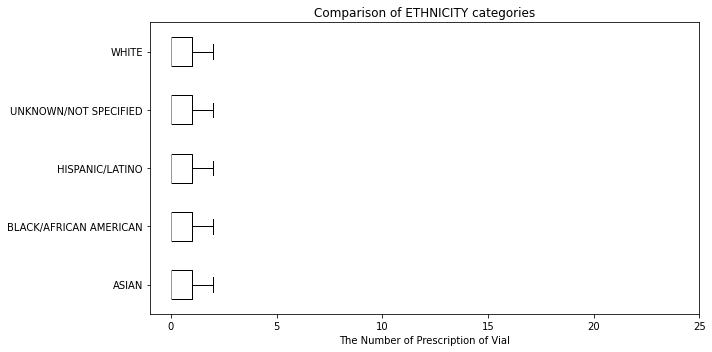

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0    12.110830  3.027708  1.307098  0.26488
Residual      3597.0  8331.944694  2.316359       NaN      NaN


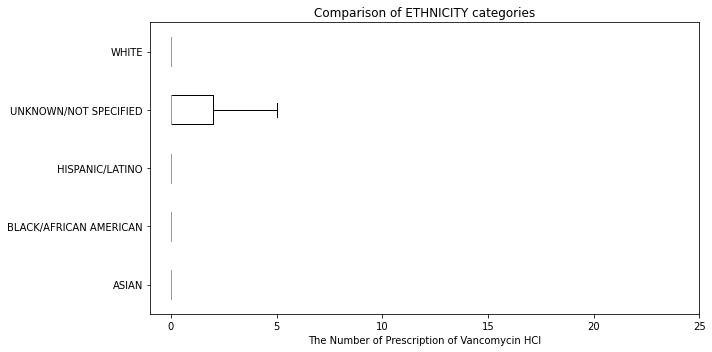

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    134.247257  33.561814  7.907989  0.000002
Residual      3597.0  15265.808268   4.244039       NaN       NaN


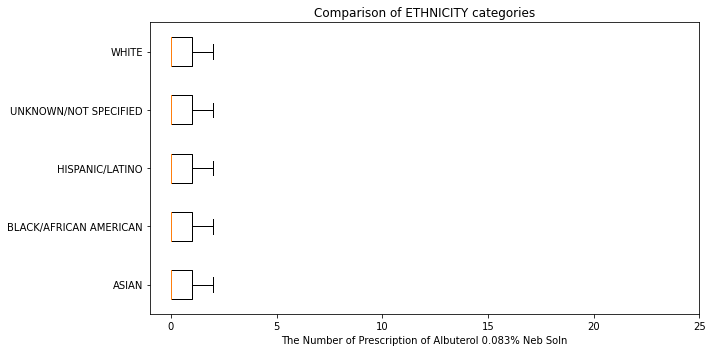

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     5.598720  1.399680  0.836055  0.502055
Residual      3597.0  6021.909608  1.674148       NaN       NaN


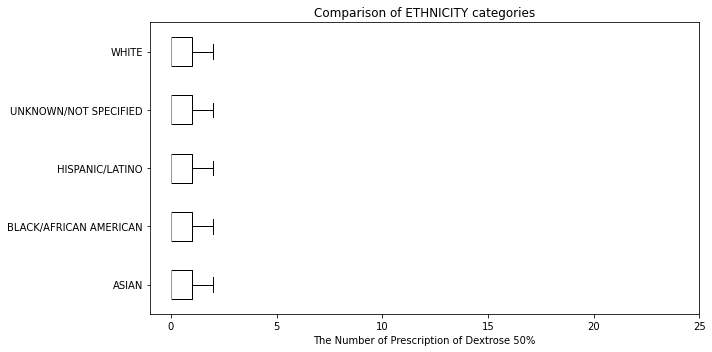

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.763284  1.940821  1.785116  0.128905
Residual      3597.0  3910.744212  1.087224       NaN       NaN


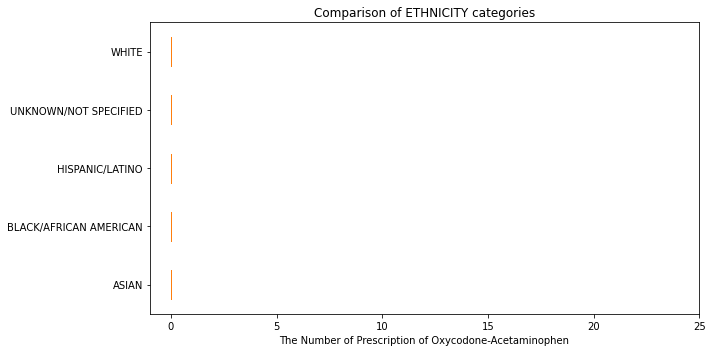

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     6.861056  1.715264  3.483445  0.007585
Residual      3597.0  1771.178922  0.492404       NaN       NaN


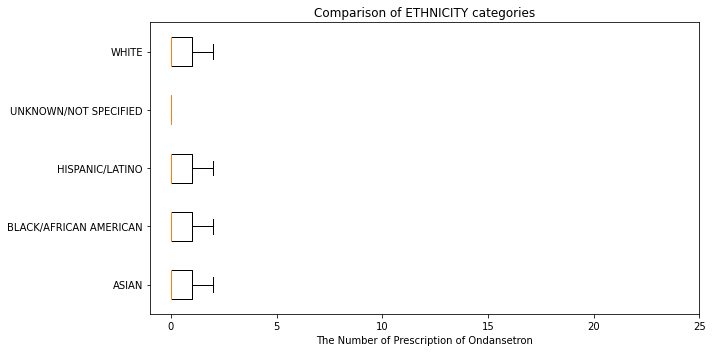

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     4.649394  1.162349  1.292975  0.270332
Residual      3597.0  3233.604076  0.898972       NaN       NaN


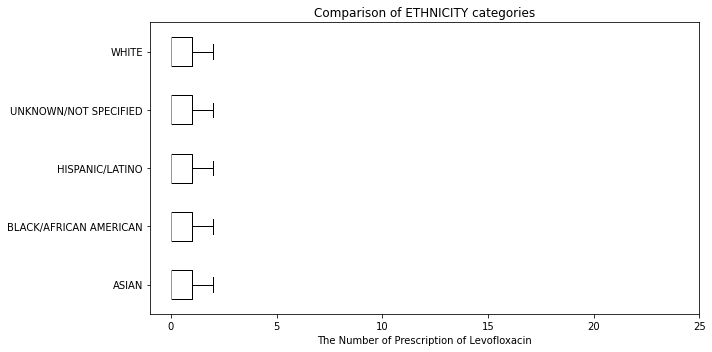

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0     6.716384  1.679096  1.089246  0.36002
Residual      3597.0  5544.850801  1.541521       NaN      NaN


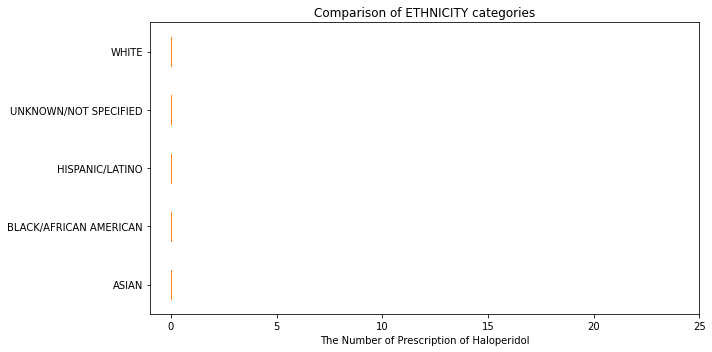

                  df        sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     37.319751  9.329938  2.658085  0.031189
Residual      3597.0  12625.550044  3.510022       NaN       NaN


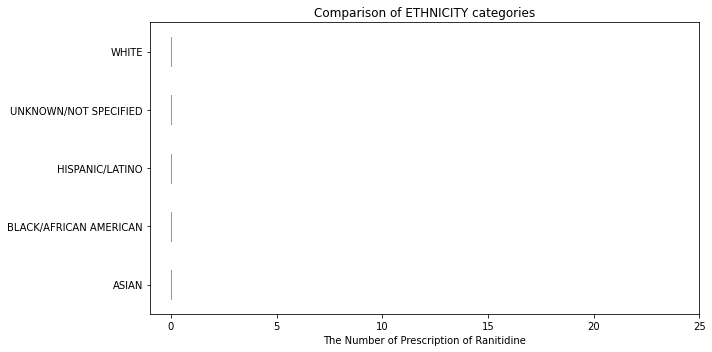

                  df       sum_sq   mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    21.484294  5.371074  10.015204  4.647910e-08
Residual      3597.0  1929.042357  0.536292        NaN           NaN


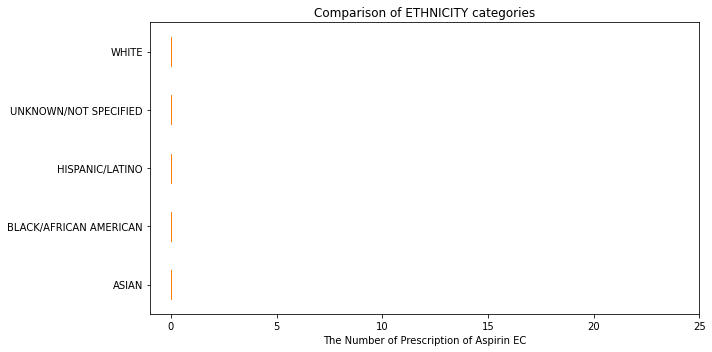

                  df       sum_sq   mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    28.744362  7.186090  16.969317  8.578369e-14
Residual      3597.0  1523.241480  0.423476        NaN           NaN


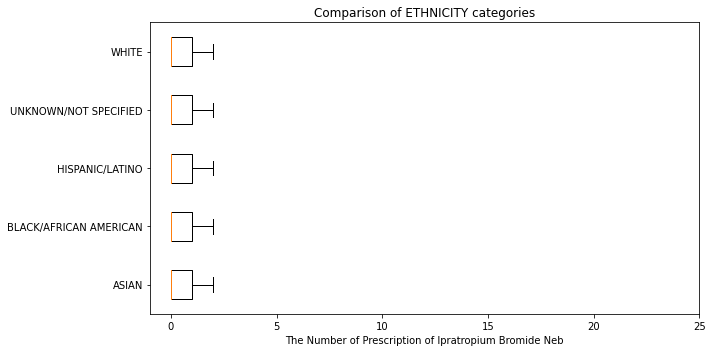

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     6.888279  1.722070  1.361289  0.244826
Residual      3597.0  4550.308001  1.265029       NaN       NaN


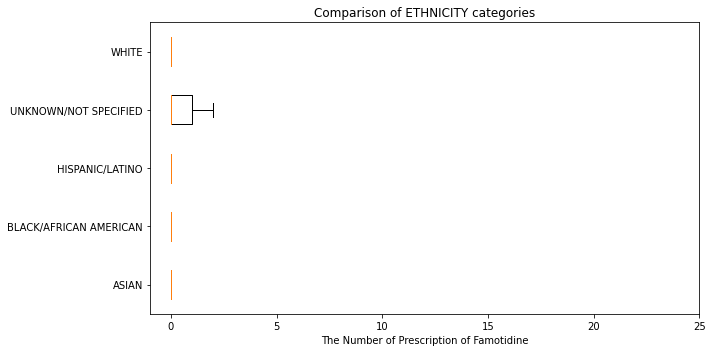

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     2.901227  0.725307  0.856193  0.489513
Residual      3597.0  3047.126813  0.847130       NaN       NaN


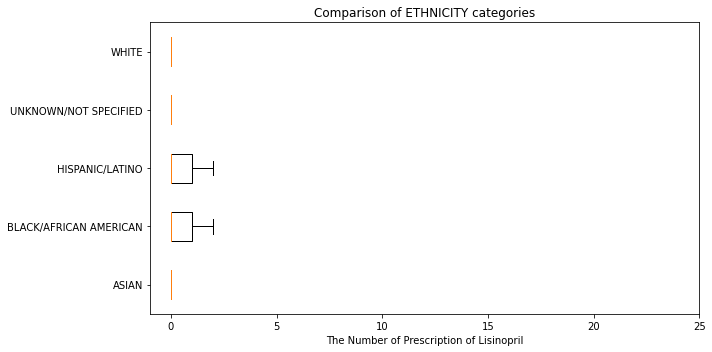

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    18.674935  4.668734  4.565847  0.001117
Residual      3597.0  3678.054660  1.022534       NaN       NaN


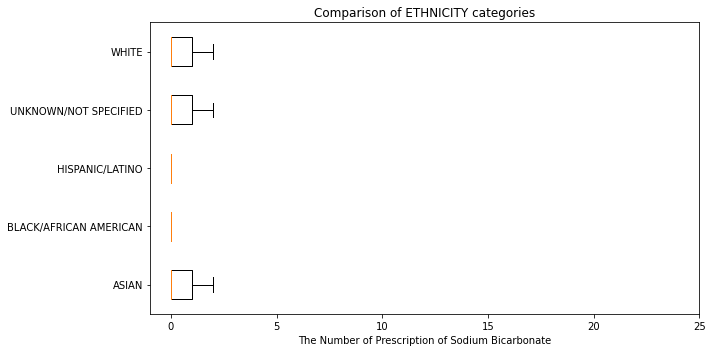

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     85.187594  21.296899  4.538639  0.001172
Residual      3597.0  16878.397358   4.692354       NaN       NaN


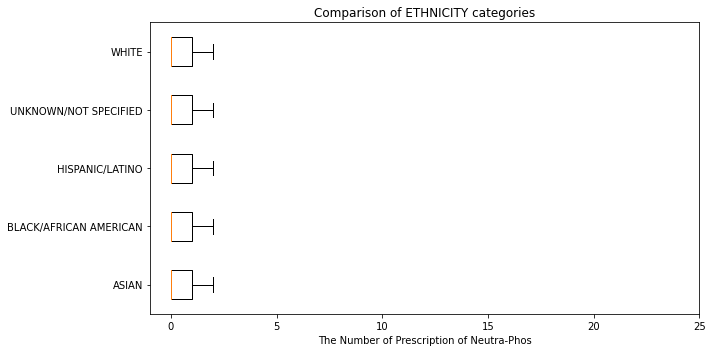

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    13.485504  3.371376  1.755714  0.134942
Residual      3597.0  6907.069743  1.920231       NaN       NaN


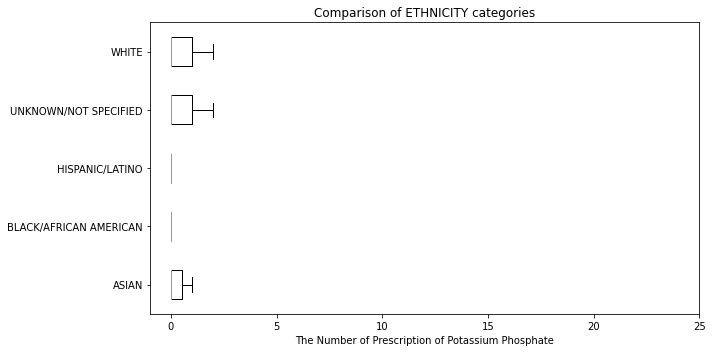

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.844665  1.961166  1.315992  0.261495
Residual      3597.0  5360.455168  1.490257       NaN       NaN


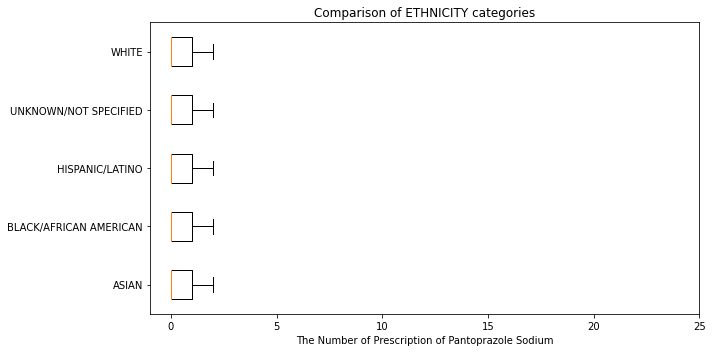

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    10.792418  2.698104  3.171992  0.013011
Residual      3597.0  3059.617632  0.850603       NaN       NaN


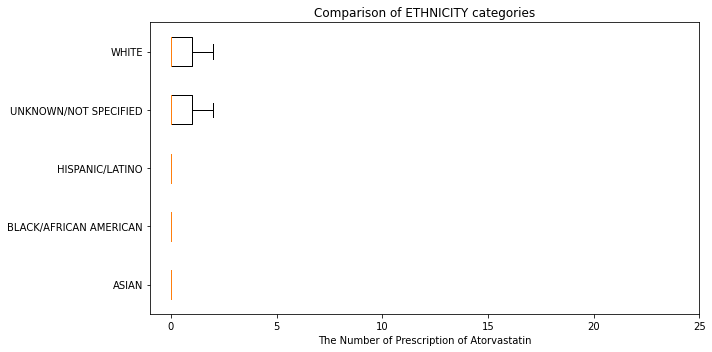

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.777122  1.944280  3.607524  0.006108
Residual      3597.0  1938.608497  0.538951       NaN       NaN


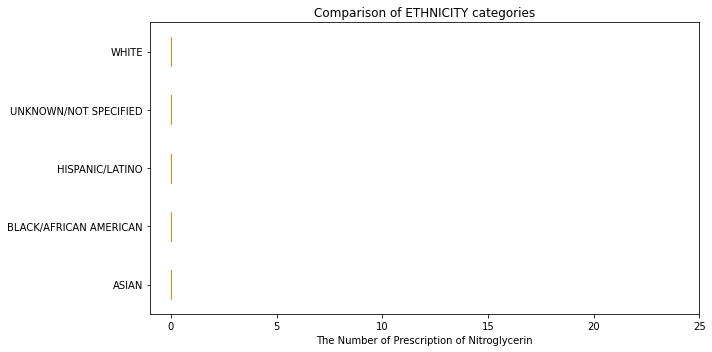

                  df       sum_sq   mean_sq         F        PR(>F)
C(ETHNICITY)     4.0    23.566952  5.891738  9.409238  1.453718e-07
Residual      3597.0  2252.316446  0.626165       NaN           NaN


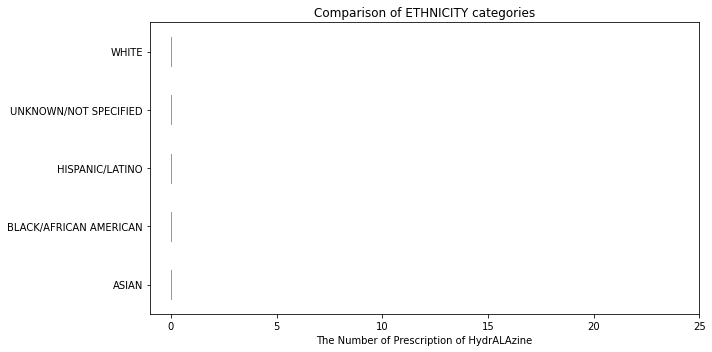

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0    11.724794  2.931199  1.157528  0.32759
Residual      3597.0  9108.652774  2.532292       NaN      NaN


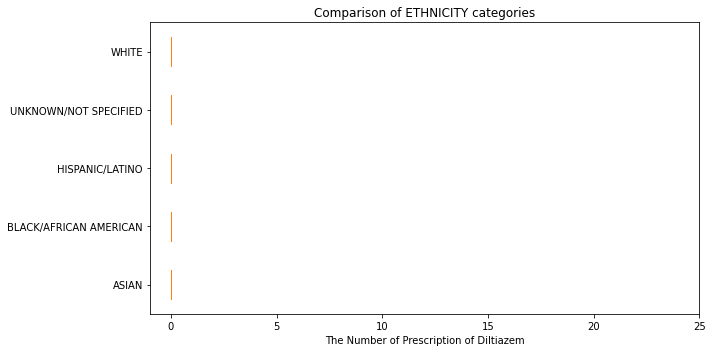

                  df        sum_sq   mean_sq       F    PR(>F)
C(ETHNICITY)     4.0     33.797569  8.449392  1.4761  0.206649
Residual      3597.0  20589.704930  5.724133     NaN       NaN


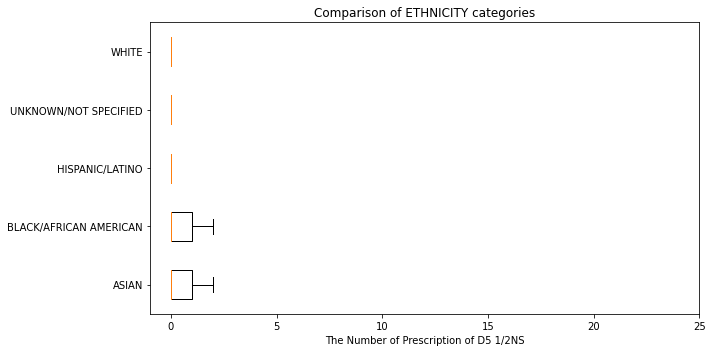

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     6.669309  1.667327  1.237851  0.292532
Residual      3597.0  4844.990880  1.346953       NaN       NaN


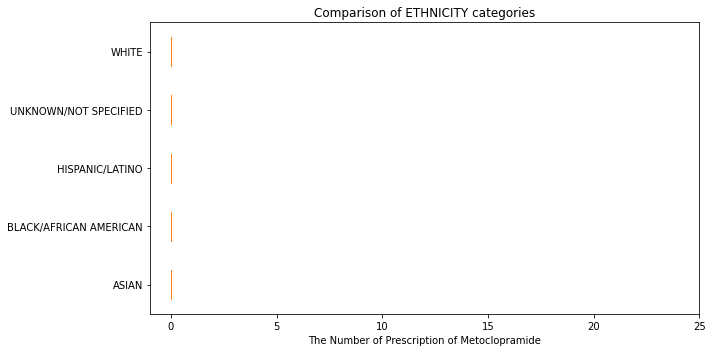

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    23.106869  5.776717  8.280041  0.000001
Residual      3597.0  2509.510843  0.697668       NaN       NaN


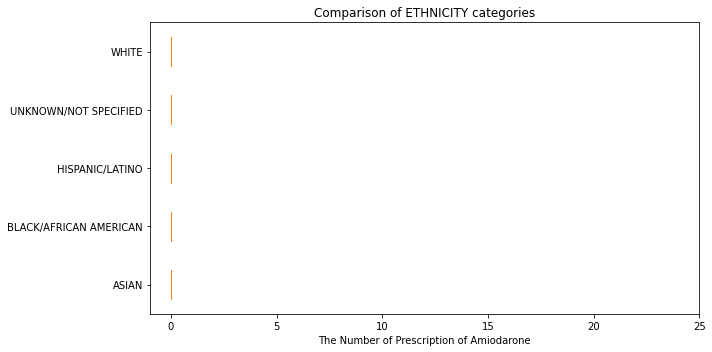

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    135.324094  33.831023  7.529918  0.000005
Residual      3597.0  16160.891620   4.492881       NaN       NaN


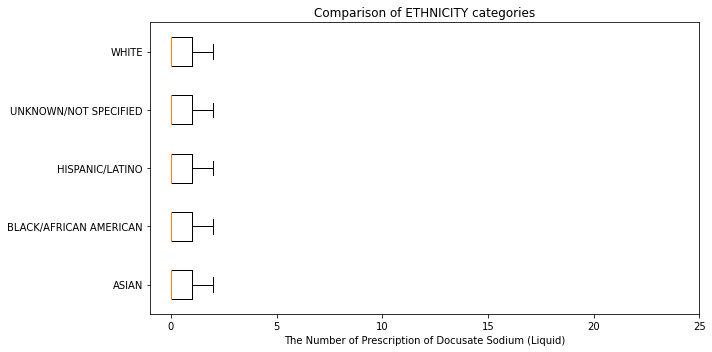

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     4.868911  1.217228  2.685906  0.029765
Residual      3597.0  1630.127203  0.453191       NaN       NaN


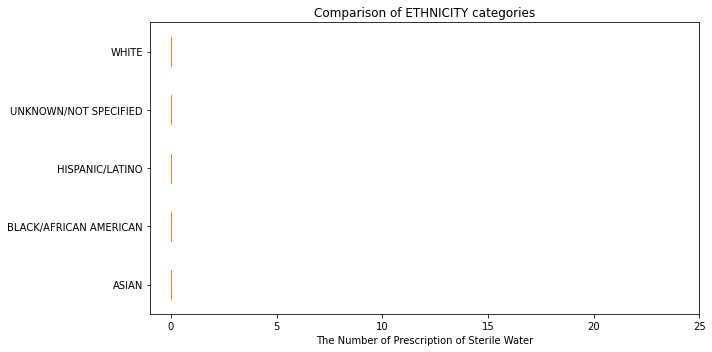

                  df        sum_sq    mean_sq        F    PR(>F)
C(ETHNICITY)     4.0    109.965142  27.491285  7.75345  0.000003
Residual      3597.0  12753.826363   3.545684      NaN       NaN


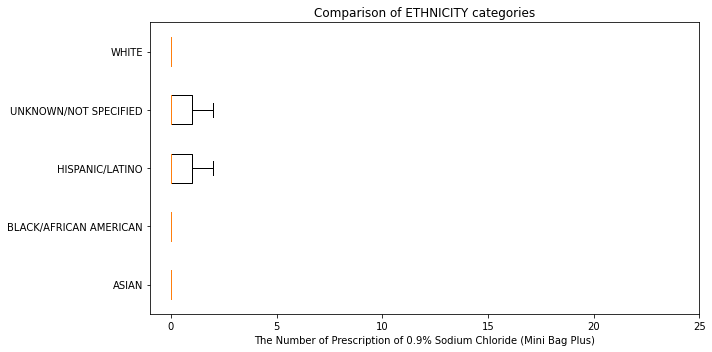

                  df        sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     30.102289  7.525572  2.285139  0.057895
Residual      3597.0  11845.882164  3.293267       NaN       NaN


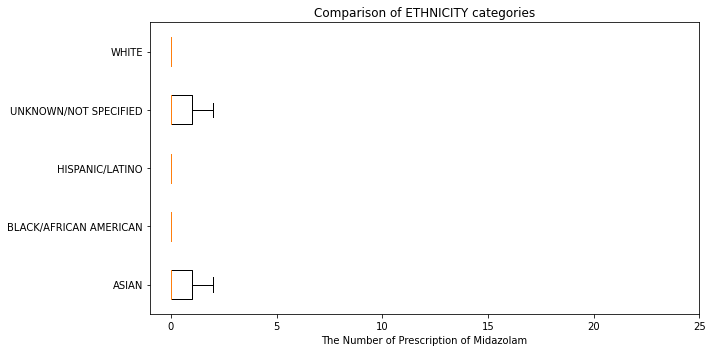

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    31.527105  7.881776  4.224853  0.002054
Residual      3597.0  6710.470674  1.865574       NaN       NaN


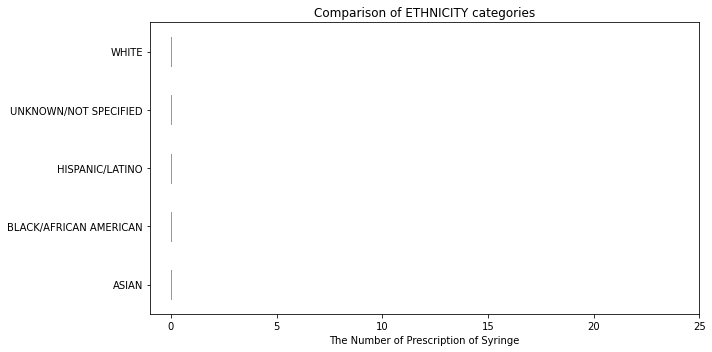

                  df       sum_sq   mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    25.613105  6.403276  11.511272  2.755604e-09
Residual      3597.0  2000.872181  0.556261        NaN           NaN


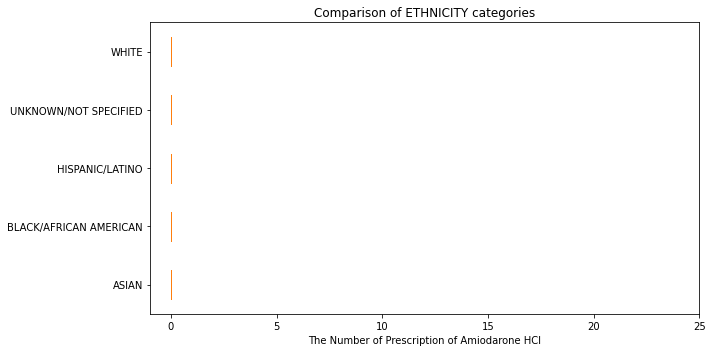

                  df        sum_sq    mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    178.307663  44.576916  11.610679  2.282978e-09
Residual      3597.0  13809.973570   3.839303        NaN           NaN


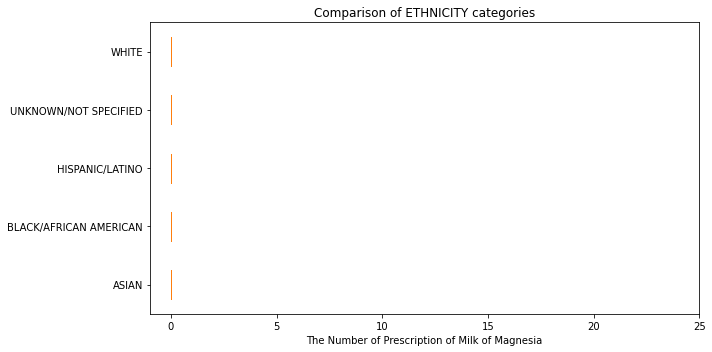

                  df      sum_sq   mean_sq        F        PR(>F)
C(ETHNICITY)     4.0    8.903154  2.225788  8.54929  7.294925e-07
Residual      3597.0  936.470805  0.260348      NaN           NaN


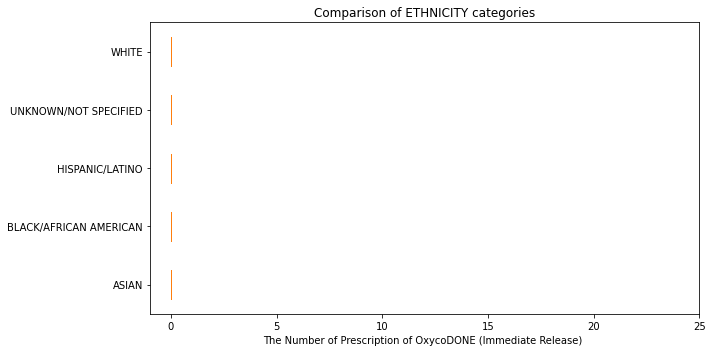

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     3.346441  0.836610  0.771267  0.543768
Residual      3597.0  3901.745452  1.084722       NaN       NaN


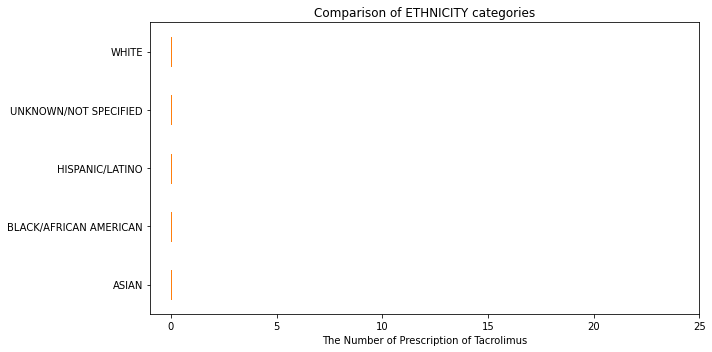

                  df        sum_sq    mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     60.902910  15.225728  1.808119  0.124357
Residual      3597.0  30289.453836   8.420754       NaN       NaN


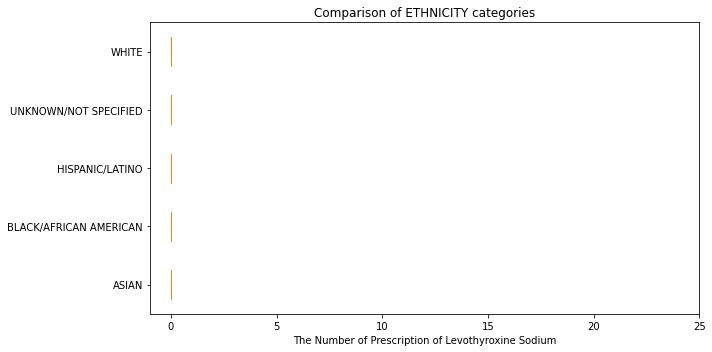

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0    12.500101  3.125025  3.191516  0.01258
Residual      3597.0  3522.061809  0.979166       NaN      NaN


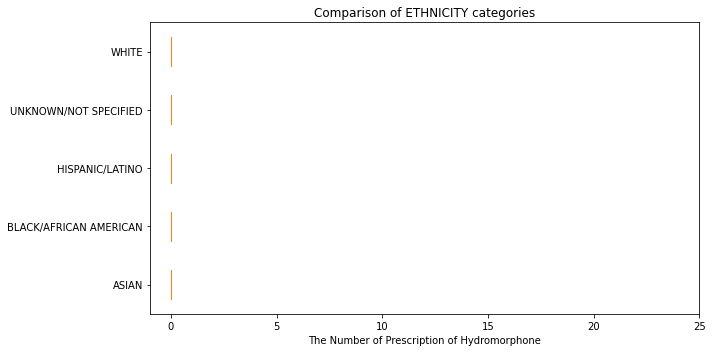

                  df       sum_sq   mean_sq        F    PR(>F)
C(ETHNICITY)     4.0     5.333697  1.333424  0.92499  0.448259
Residual      3597.0  5185.273744  1.441555      NaN       NaN


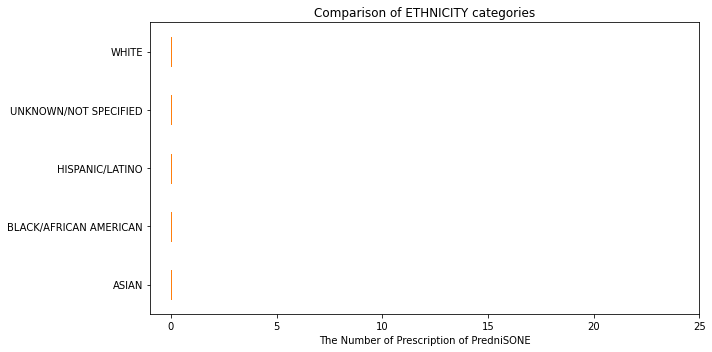

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    13.131285  3.282821  1.436055  0.219325
Residual      3597.0  8222.743229  2.286000       NaN       NaN


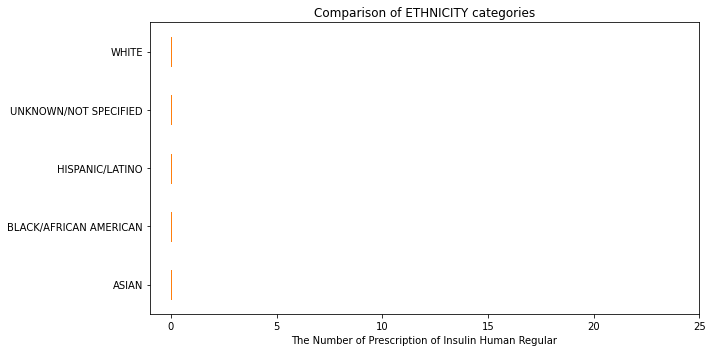

                  df       sum_sq   mean_sq        F    PR(>F)
C(ETHNICITY)     4.0     2.930406  0.732602  1.20395  0.306929
Residual      3597.0  2188.767540  0.608498      NaN       NaN


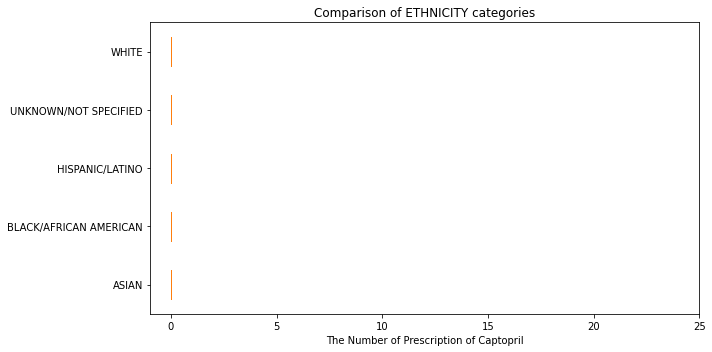

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    34.250021  8.562505  6.750931  0.000021
Residual      3597.0  4562.234432  1.268344       NaN       NaN


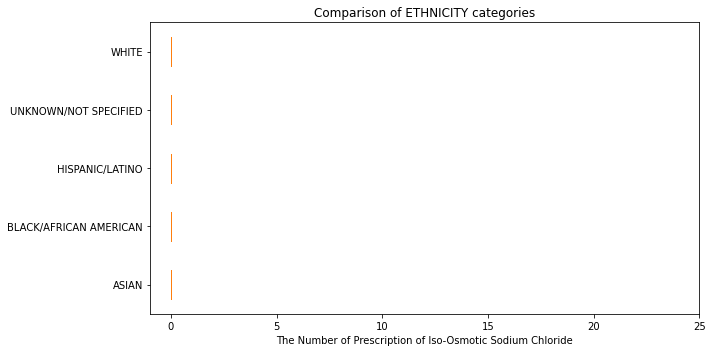

                  df       sum_sq   mean_sq        F    PR(>F)
C(ETHNICITY)     4.0     5.205836  1.301459  2.66164  0.031003
Residual      3597.0  1758.820816  0.488969      NaN       NaN


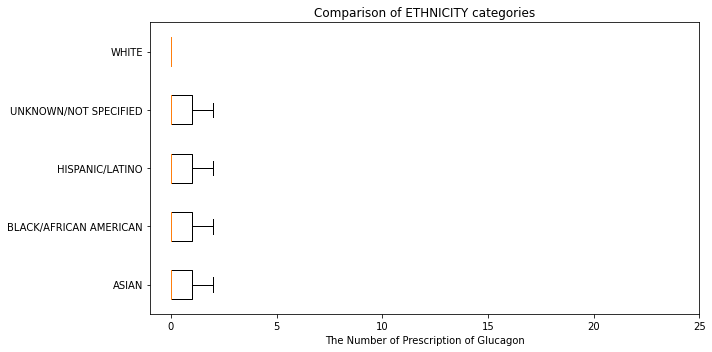

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     4.126860  1.031715  2.884595  0.021273
Residual      3597.0  1286.516394  0.357664       NaN       NaN


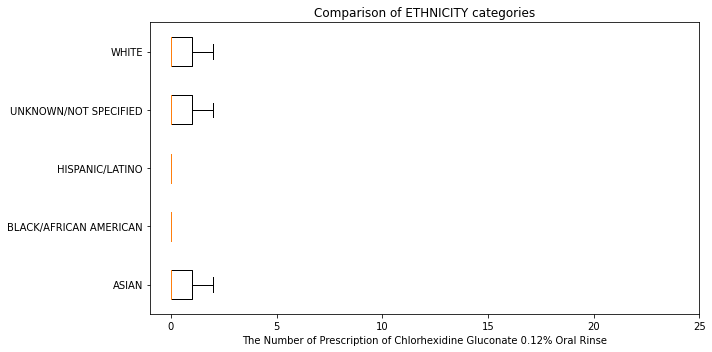

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     3.612459  0.903115  2.237001  0.062633
Residual      3597.0  1452.169051  0.403717       NaN       NaN


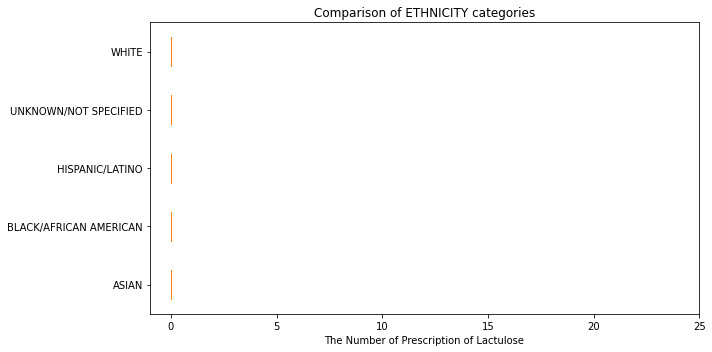

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    10.415000  2.603750  1.825724  0.120976
Residual      3597.0  5129.849575  1.426147       NaN       NaN


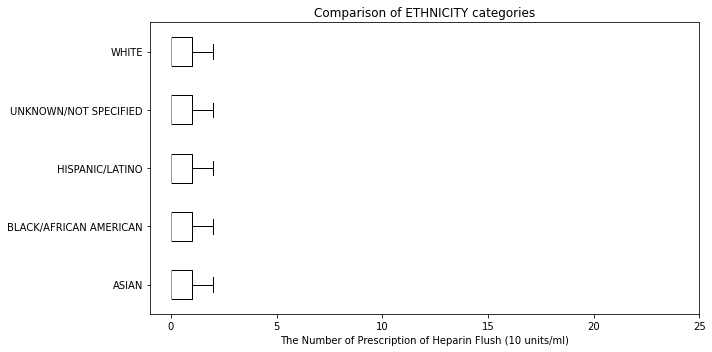

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     4.184225  1.046056  1.241461  0.291032
Residual      3597.0  3030.836319  0.842601       NaN       NaN


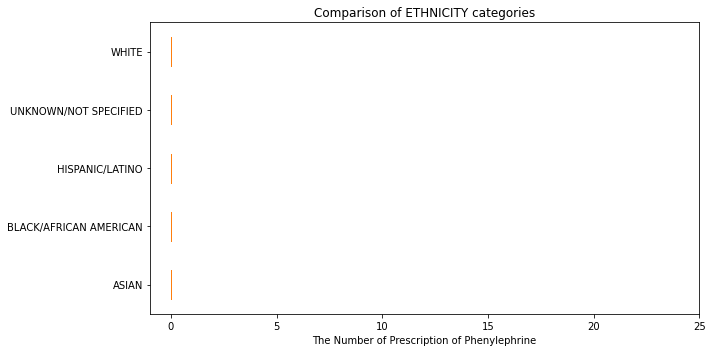

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0     8.599168  2.149792  2.595263  0.03465
Residual      3597.0  2979.583231  0.828352       NaN      NaN


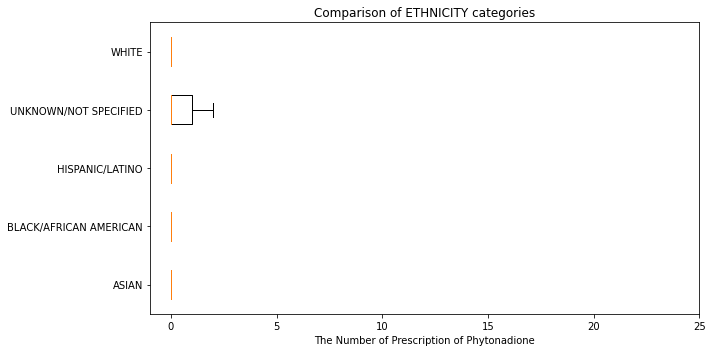

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.739851  1.934963  1.883646  0.110446
Residual      3597.0  3694.994463  1.027243       NaN       NaN


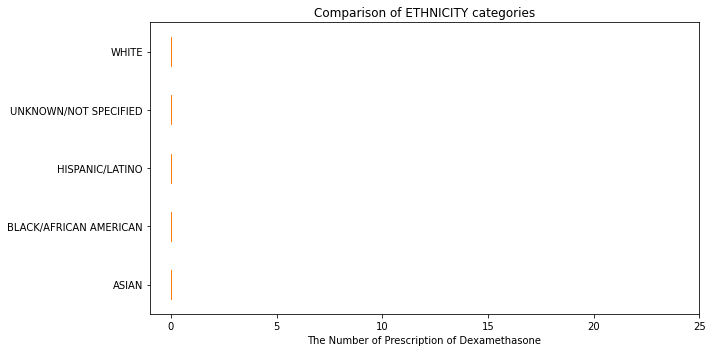

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     9.550706  2.387676  1.300194  0.267533
Residual      3597.0  6605.530915  1.836400       NaN       NaN


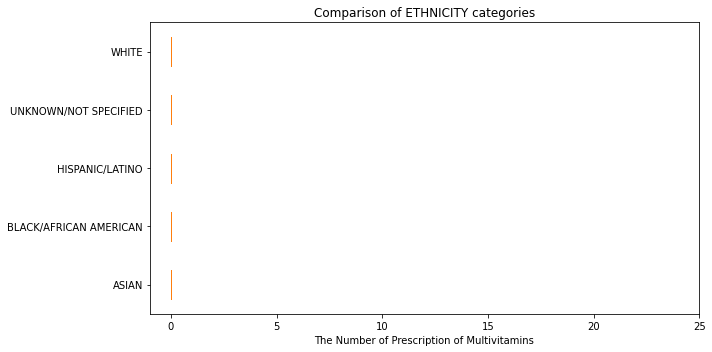

                  df       sum_sq   mean_sq         F   PR(>F)
C(ETHNICITY)     4.0     6.787090  1.696773  4.237019  0.00201
Residual      3597.0  1440.468046  0.400464       NaN      NaN


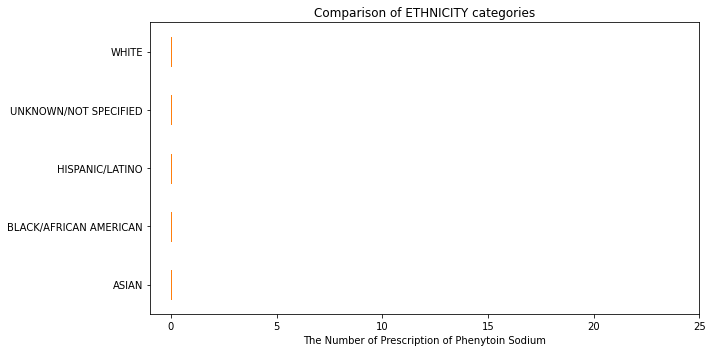

                  df       sum_sq  mean_sq        F    PR(>F)
C(ETHNICITY)     4.0     9.101081  2.27527  1.80673  0.124627
Residual      3597.0  4529.810912  1.25933      NaN       NaN


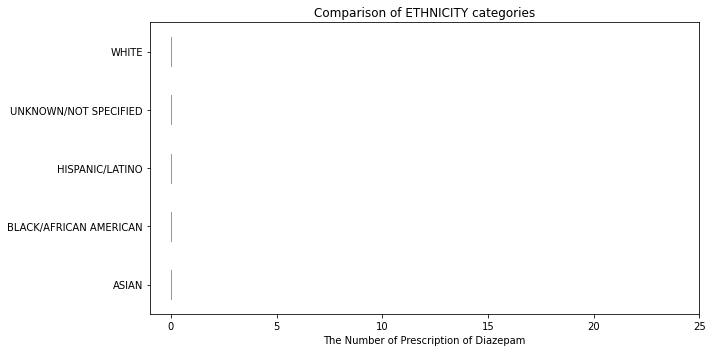

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     3.426539  0.856635  1.664414  0.155381
Residual      3597.0  1851.291118  0.514676       NaN       NaN


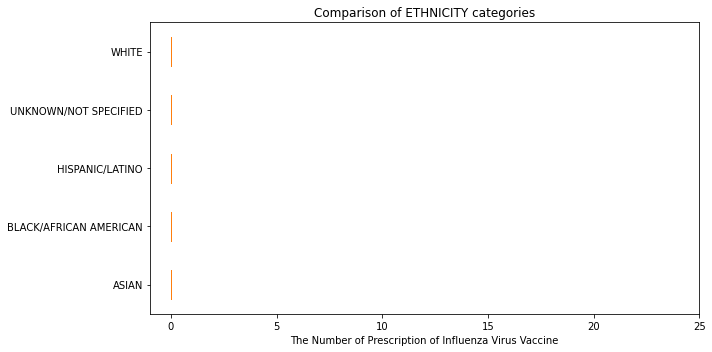

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     2.389920  0.597480  1.737801  0.138747
Residual      3597.0  1236.698364  0.343814       NaN       NaN


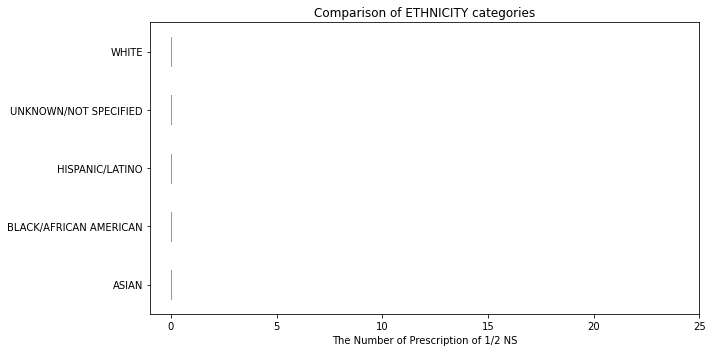

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    13.352604  3.338151  3.925185  0.003494
Residual      3597.0  3059.048284  0.850444       NaN       NaN


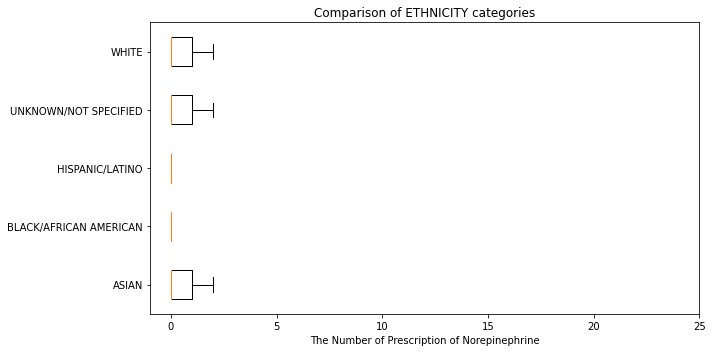

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    37.049225  9.262306  6.742272  0.000021
Residual      3597.0  4941.437172  1.373766       NaN       NaN


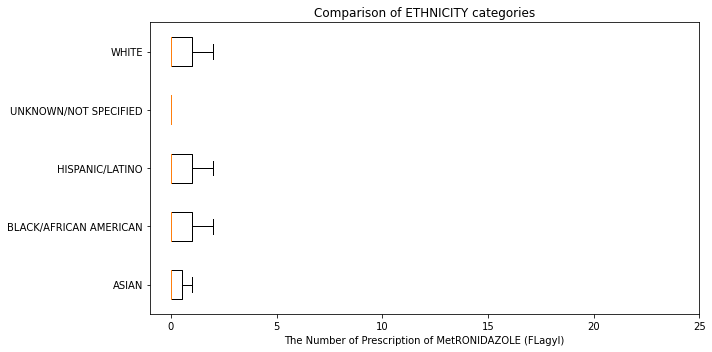

                  df      sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     4.54014  1.135035  1.075003  0.367096
Residual      3597.0  3797.86991  1.055844       NaN       NaN


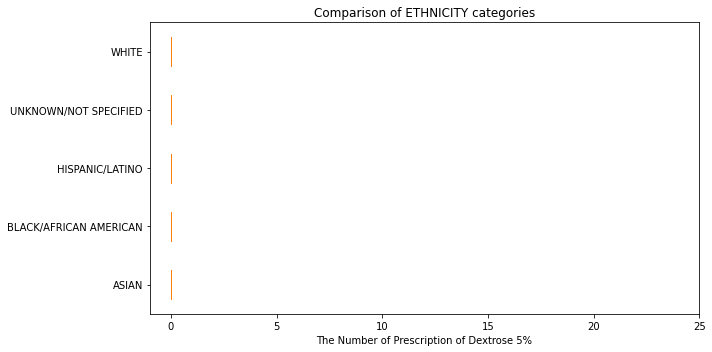

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     8.726054  2.181514  3.456177  0.007954
Residual      3597.0  2270.399987  0.631193       NaN       NaN


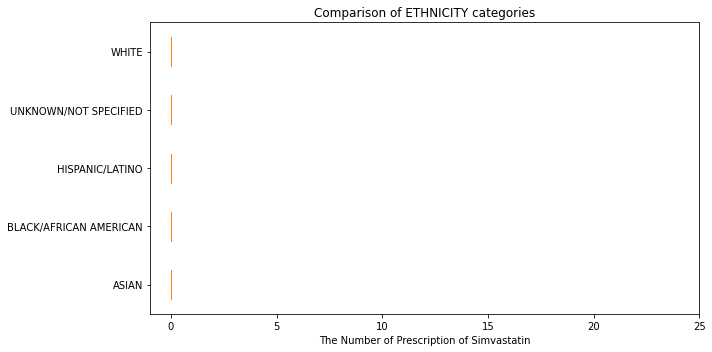

                  df      sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     0.55553  0.138882  0.400936  0.808103
Residual      3597.0  1245.98417  0.346395       NaN       NaN


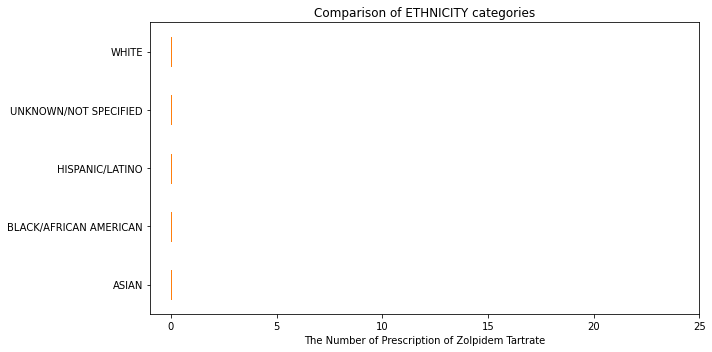

                  df       sum_sq   mean_sq         F        PR(>F)
C(ETHNICITY)     4.0    12.459600  3.114900  9.329735  1.687963e-07
Residual      3597.0  1200.923242  0.333868       NaN           NaN


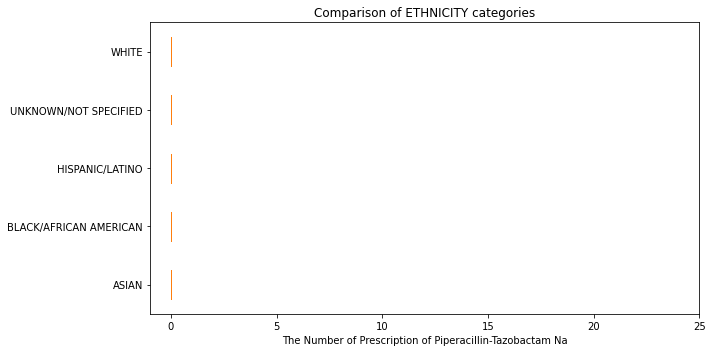

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    11.251394  2.812849  2.457812  0.043561
Residual      3597.0  4116.594525  1.144452       NaN       NaN


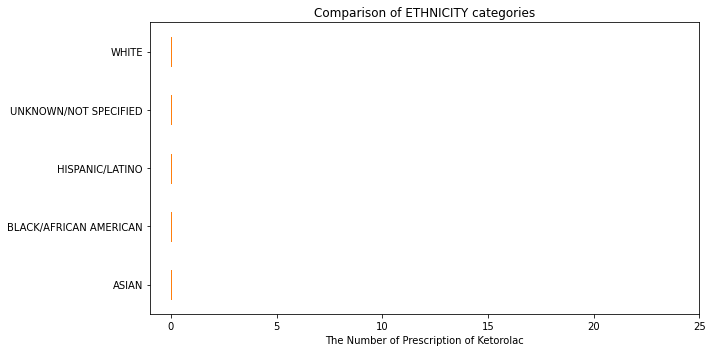

                  df      sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    0.972928  0.243232  2.338632  0.053032
Residual      3597.0  374.110081  0.104006       NaN       NaN


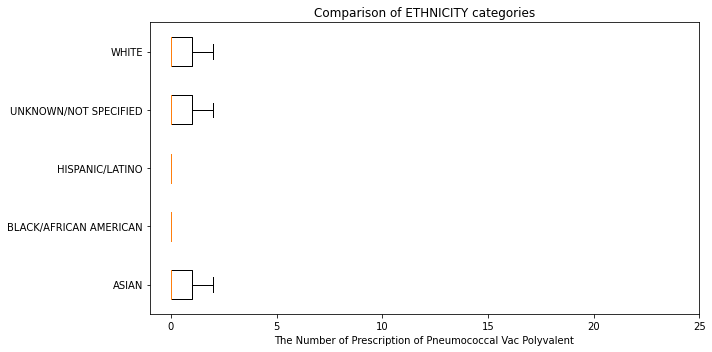

                  df       sum_sq   mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    21.991025  5.497756  16.054277  4.908351e-13
Residual      3597.0  1231.785765  0.342448        NaN           NaN


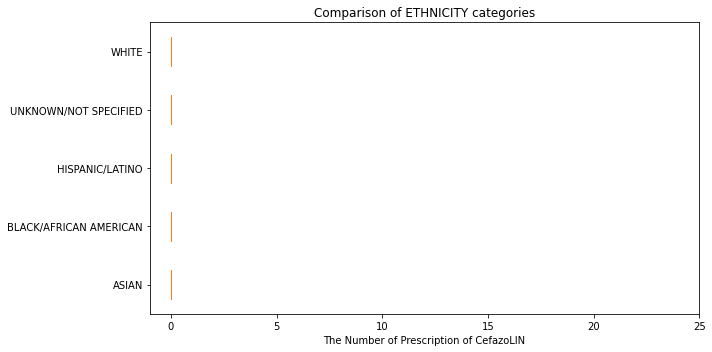

                  df      sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    1.338330  0.334583  1.453276  0.213792
Residual      3597.0  828.124468  0.230226       NaN       NaN


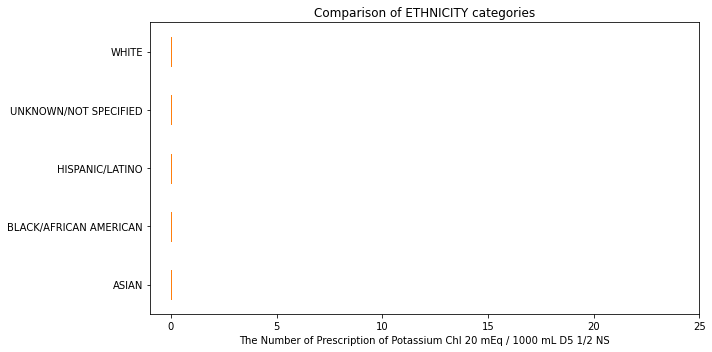

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     7.300089  1.825022  2.503852  0.040356
Residual      3597.0  2621.802632  0.728886       NaN       NaN


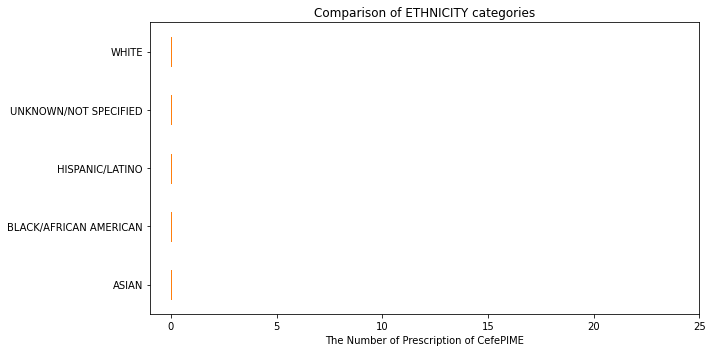

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     3.036644  0.759161  0.583179  0.674839
Residual      3597.0  4682.444755  1.301764       NaN       NaN


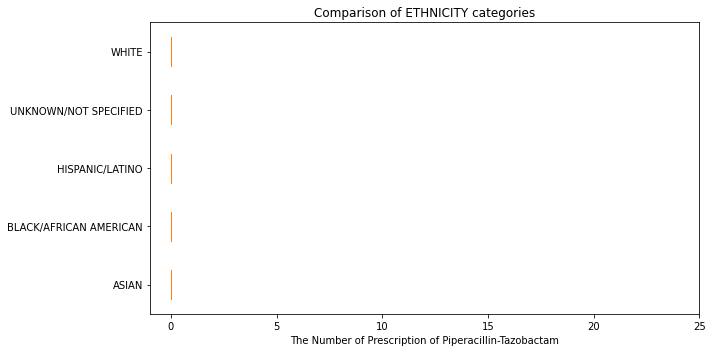

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     1.715143  0.428786  0.324877  0.861437
Residual      3597.0  4747.464479  1.319840       NaN       NaN


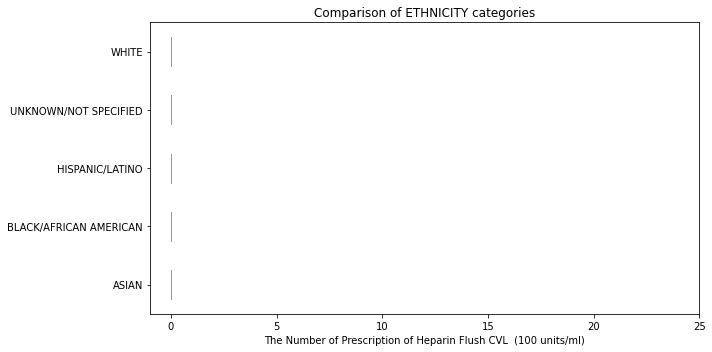

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     1.310567  0.327642  0.517257  0.723068
Residual      3597.0  2278.417362  0.633422       NaN       NaN


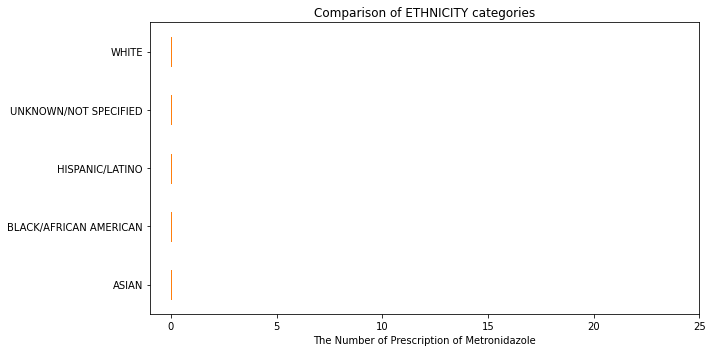

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0    24.541437  6.135359  6.624893  0.000026
Residual      3597.0  3331.206481  0.926107       NaN       NaN


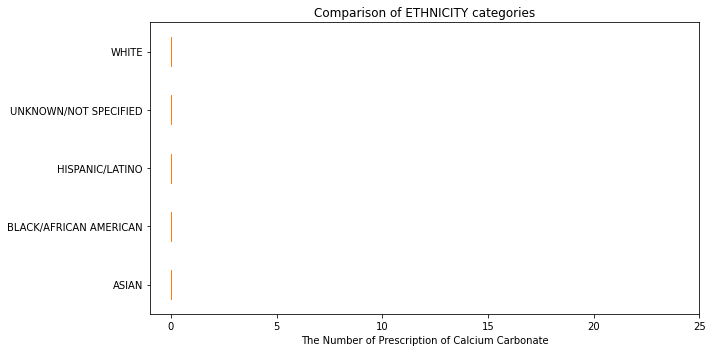

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     5.069541  1.267385  3.756104  0.004707
Residual      3597.0  1213.700309  0.337420       NaN       NaN


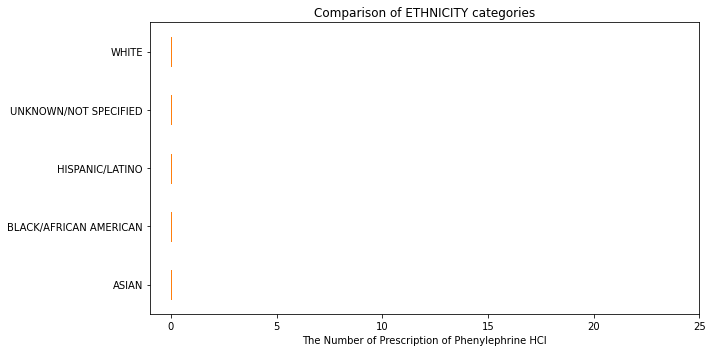

                  df       sum_sq   mean_sq          F        PR(>F)
C(ETHNICITY)     4.0    26.499882  6.624971  10.543304  1.716997e-08
Residual      3597.0  2260.204171  0.628358        NaN           NaN


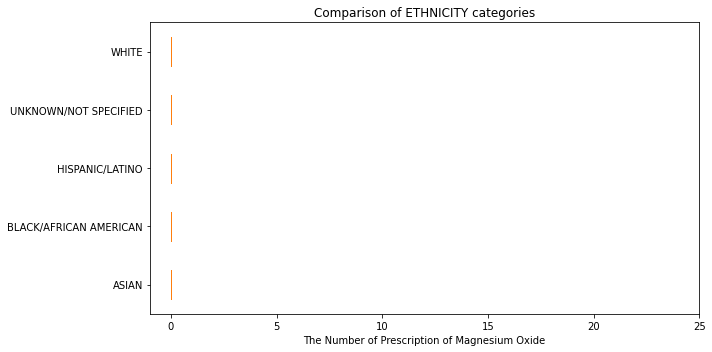

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     2.748617  0.687154  1.184203  0.315583
Residual      3597.0  2087.220567  0.580267       NaN       NaN


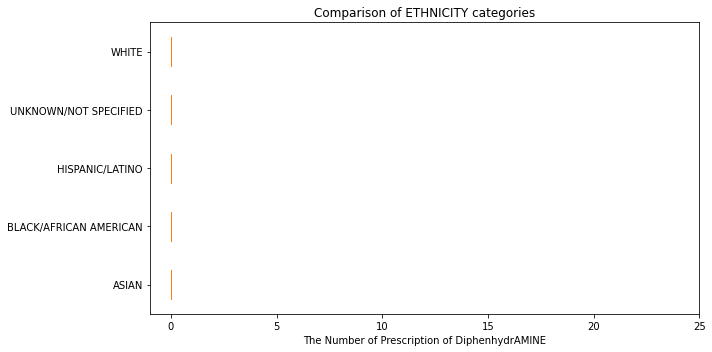

                  df       sum_sq   mean_sq         F    PR(>F)
C(ETHNICITY)     4.0     6.001947  1.500487  2.839997  0.022946
Residual      3597.0  1900.442251  0.528341       NaN       NaN


In [ ]:
for drug in top_drug:
    result = df_infectious_senior[['ETHNICITY', drug]].groupby('ETHNICITY').mean().reset_index()

    categories = result['ETHNICITY'].values.tolist()

    hist_data = []
    for cat in categories:
        hist_data.append(df_infectious_senior.loc[df_infectious_senior['ETHNICITY'] == cat, drug].values)

    fig, ax = plt.subplots(figsize=(10,5))
    ax.boxplot(hist_data, showfliers=False, vert=False)
    ax.set_xlim((-1, 25))
    ax.set_yticklabels(categories)
    ax.set_xlabel('The Number of Prescription of {}'.format(drug))
    #ax.tick_params(left=False, right=False) 
    ax.set_title('Comparison of {} categories'.format('ETHNICITY'))
    plt.tight_layout()
    plt.show();

    tmp_anova = df_infectious_senior[['ETHNICITY', drug]]
    tmp_anova.columns = ['ETHNICITY', 'DRUG']

    model = ols('DRUG ~ C(ETHNICITY)', tmp_anova).fit()
    table = anova_lm(model)
    print(table)

In [ ]:
col_prefix = ['ADM', 'INS', 'REL', 'MAR', 'ETH']
col_category = ['ADMISSION_TYPE', 'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY']

df = pd.get_dummies(df, prefix=col_prefix, columns=col_category)
df

In [ ]:
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'WHITE']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'UNKNOWN/NOT SPECIFIED']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'BLACK']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'HISPANIC/LATINO']))
print(scipy.stats.shapiro(tmp_anova.DRUG[tmp_anova.ETHNICITY == 'ASIAN']))

ShapiroResult(statistic=0.2388683557510376, pvalue=0.0)
ShapiroResult(statistic=0.14782041311264038, pvalue=0.0)


ValueError: Data must be at least length 3.

In [ ]:
comp = MultiComparison(tmp_anova.DRUG, tmp_anova.ETHNICITY)
result = comp.allpairtest(scipy.stats.ttest_ind, method='bonf')
result[0]

group1,group2,stat,pval,pval_corr,reject
ASIAN,BLACK/AFRICAN AMERICAN,0.0497,0.9604,1.0,False
ASIAN,HISPANIC/LATINO,-1.3435,0.1799,1.0,False
ASIAN,UNKNOWN/NOT SPECIFIED,-0.1713,0.864,1.0,False
ASIAN,WHITE,-1.4547,0.1459,1.0,False
BLACK/AFRICAN AMERICAN,HISPANIC/LATINO,-2.026,0.043,0.4305,False
BLACK/AFRICAN AMERICAN,UNKNOWN/NOT SPECIFIED,-0.3412,0.733,1.0,False
BLACK/AFRICAN AMERICAN,WHITE,-2.6364,0.0084,0.0843,False
HISPANIC/LATINO,UNKNOWN/NOT SPECIFIED,1.3623,0.1735,1.0,False
HISPANIC/LATINO,WHITE,0.067,0.9466,1.0,False
UNKNOWN/NOT SPECIFIED,WHITE,-2.0884,0.0369,0.3686,False


In [ ]:
hsd = pairwise_tukeyhsd(tmp_anova['DRUG'], tmp_anova['ETHNICITY'], alpha=0.05)
hsd.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
ASIAN,BLACK/AFRICAN AMERICAN,-0.0019,0.9,-0.1559,0.1521,False
ASIAN,HISPANIC/LATINO,0.0884,0.7084,-0.108,0.2848,False
ASIAN,UNKNOWN/NOT SPECIFIED,0.009,0.9,-0.1467,0.1646,False
ASIAN,WHITE,0.0842,0.4935,-0.0589,0.2274,False
BLACK/AFRICAN AMERICAN,HISPANIC/LATINO,0.0903,0.5329,-0.07,0.2506,False
BLACK/AFRICAN AMERICAN,UNKNOWN/NOT SPECIFIED,0.0109,0.9,-0.0956,0.1173,False
BLACK/AFRICAN AMERICAN,WHITE,0.0862,0.0546,-0.001,0.1733,False
HISPANIC/LATINO,UNKNOWN/NOT SPECIFIED,-0.0794,0.6452,-0.2413,0.0824,False
HISPANIC/LATINO,WHITE,-0.0042,0.9,-0.1541,0.1457,False
UNKNOWN/NOT SPECIFIED,WHITE,0.0753,0.1507,-0.0147,0.1653,False


In [ ]:
nan_cols = [i for i in adm_pres_df.columns if adm_pres_df[i].isnull().any()]
print(nan_cols)

In [ ]:
dt = adm_pres_df.copy()
print(dt.shape)
dt.head()

In [ ]:
training_set = dt.copy()

print('WHITE: {} | UNKNOWN/NOT SPECIFIED: {} | BLACK: {} | HISPANIC/LATINO: {} | ASIAN: {}'.format(len(training_set[training_set['ETHNICITY']=='WHITE']),\
                                         len(training_set[training_set['ETHNICITY']=='UNKNOWN/NOT SPECIFIED']),
                                         len(training_set[training_set['ETHNICITY']=='BLACK']),
                                         len(training_set[training_set['ETHNICITY']=='HISPANIC/LATINO']),
                                         len(training_set[training_set['ETHNICITY']=='ASIAN'])))

sns.countplot(x='ETHNICITY', data=training_set)

In [ ]:
white_yes = dt.loc[dt['ETHNICITY'] == 'WHITE']
white_yes

In [ ]:
white_no = dt.loc[dt['ETHNICITY'] != 'WHITE']
white_no

In [ ]:
# Oversample the minority class by using SMOTE
white_yes = dt.loc[dt['ETHNICITY'] == 'WHITE']
white_no = dt.loc[(dt['ETHNICITY'] == 'BLACK') | (dt['ETHNICITY'] == 'HISPANIC/LATINO') | (dt['ETHNICITY'] == 'ASIAN')]

white_yes_undersample = resample(
    white_yes,
    replace = False,
    n_samples = len(white_no),
    random_state=42
)

#pd.concat([white_no, dt.loc[dt['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED']], axis=0)
undersample = pd.concat([white_yes_undersample, pd.concat([white_no, dt.loc[dt['ETHNICITY'] == 'UNKNOWN/NOT SPECIFIED']], axis=0)], axis=0)
#print('Stroke: {} | No Stroke: {}'.format(len(training_set_resampled[training_set_resampled['stroke']==1]),\
#                                          len(training_set_resampled[training_set_resampled['stroke']==0])))

sns.countplot(x='ETHNICITY', data=undersample)

In [ ]:
dt = undersample.copy()

## One-Hot Encoding: Categorical Columns

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['ETHNICITY'], prefix='ETHNICITY')], axis=1).drop(['ETHNICITY'], axis=1)
dt.head()

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['ADMISSION_TYPE'], prefix='ADMISSION_TYPE')], axis=1).drop(['ADMISSION_TYPE'], axis=1)
dt.head()

### One-Hot Encoding: MARITAL_STATUS

In [ ]:
"""dt = pd.concat([dt, pd.get_dummies(dt['MARITAL_STATUS'], prefix='MARITAL_STATUS')], axis=1).drop(['MARITAL_STATUS'], axis=1)
dt.head()"""

### One-Hot Encoding: INSURANCE

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['INSURANCE'], prefix='INSURANCE')], axis=1).drop(['INSURANCE'], axis=1)
dt.head()

### One-Hot Encoding: DIAGNOSIS

In [ ]:
dt = pd.concat([dt, pd.get_dummies(dt['DIAGNOSIS'], prefix='DIAGNOSIS')], axis=1).drop(['DIAGNOSIS'], axis=1)
dt.head()

## Split into Train/Test

In [ ]:
from sklearn.model_selection import train_test_split

target = dt[['ETHNICITY_WHITE', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN']]
feature = dt.drop(['SUBJECT_ID', 'HADM_ID', 'MARITAL_STATUS', 'ETHNICITY_WHITE', 'ETHNICITY_UNKNOWN/NOT SPECIFIED', 'ETHNICITY_BLACK', 'ETHNICITY_HISPANIC/LATINO', 'ETHNICITY_ASIAN'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.2, random_state=42)
print('X_train: {} | X_test: {} | y_train: {} | y_test: {}'.format(len(X_train), len(X_test), len(y_train), len(y_test)))

In [ ]:
clf_rf = RandomForestClassifier()

hyper_param = {
    'n_estimators': list(range(10, 100, 10)),
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(10, 110, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rs_rf = RandomizedSearchCV(clf_rf, hyper_param, n_iter = 100, cv=3, verbose=2, n_jobs=-1)
rs_rf.fit(X_train, y_train)

In [ ]:
rs_rf.best_params_

In [ ]:
clf_rf = RandomForestClassifier()

hyper_param = {
    'n_estimators': list(range(10, 100, 10)),
    'max_features': ['auto', 'sqrt'],
    'criterion': ['gini', 'entropy'],
    'max_depth': list(range(10, 110, 11)),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

gs_rf = GridSearchCV(clf_rf, hyper_param, cv=3, verbose=2, n_jobs=-1)
gs_rf.fit(X_train, y_train)

In [ ]:
gs_rf.best_params_

In [ ]:
for i, score_accuracy, comb in zip(range(1, len(gs_dt.cv_results_['params'])+1), gs_dt.cv_results_['mean_test_score'], gs_dt.cv_results_['params']):
    print('Hyperparameter Combindation #{}: {}\nTest Score: {}\n'.format(i, comb, score_accuracy))
    
print('The optimal combination of hyperparameters is {}'.format(gs_dt.best_params_))
print('The total number of hyperparameter combinations tested is {}'.format(len(gs_dt.cv_results_['params'])))

In [ ]:
for i, score_accuracy, comb in zip(range(1, len(rs_rf.cv_results_['params'])+1), rs_rf.cv_results_['mean_test_score'], rs_rf.cv_results_['params']):
    print('Hyperparameter Combindation #{}: {}\nTest Score: {}\n'.format(i, comb, score_accuracy))
    
print('The optimal combination of hyperparameters is {}'.format(rs_rf.best_params_))
print('The total number of hyperparameter combinations tested is {}'.format(len(rs_rf.cv_results_['params'])))

In [ ]:
clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=19)
clf_dt.fit(X_train, y_train)

y_pred_dt = clf_dt.predict(X_test)

eval_dt_accuracy = accuracy_score(y_test, y_pred_dt)
eval_dt_precision = precision_score(y_test, y_pred_dt)
eval_dt_recall = recall_score(y_test, y_pred_dt)
print('Accuracy: {} | Precision: {} | Recall: {}'.format(round(eval_dt_accuracy, 2), round(eval_dt_precision, 2), round(eval_dt_recall, 2)))

NameError: ignored